# Project：멋진 챗봇 만들기

&nbsp;

&nbsp;

## 라이브러리
<hr>

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import re
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.initializers import Constant

import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

import matplotlib.pyplot as plt

import konlpy
from konlpy.tag import Mecab
import nltk

## BLEU score
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from collections import Counter

## Progress
from tqdm.notebook import tqdm


print(np.__version__)
print(pd.__version__)
print(tf.__version__)

print(gensim.__version__)
print(konlpy.__version__)
print(nltk.__version__)

1.21.4
1.3.3
2.6.0
3.8.3
0.5.2
3.6.5


&nbsp;

## Step 1. 데이터 다운로드

<hr>

준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 `ChatbotData.csv`라는 이름으로 저장되어 있을거예요. `csv` 파일을 읽는 데에는 `pandas` 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 `questions`, `answers` 변수에 나눠서 저장하세요!

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data)

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다.

데이터는 아래의 링크에서 다운로드 하였다.

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

링크에서 안내하고 있는 내용은 아래와 같다. 

──────────────────────────────────────

- Chatbot_data_for_Korean v1.0
    
  + Data description.
  
    * 인공데이터입니다. 일부 이별과 관련된 질문에서 <br>다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 <br>자주 나오는 이야기들을 참고하여 제작하였습니다. <br>가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 <br>챗봇이 위로한다는 취지로 답변을 작성하였습니다.
    
    * 1. 챗봇 트레이닝용 문답 페어 11,876개
    
    * 2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링


여기서는 문답 페어(Q, A) 데이터만 사용하고, 라벨은 사용하지 않는다.

──────────────────────────────────────



In [2]:
## 파일 가져오기 및 경로 지정
songys_chabot_data_path =  tf.keras.utils.get_file(
    os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData.csv",
    origin="https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv")
df_songys_chabot = pd.read_csv(songys_chabot_data_path)

In [3]:
## 라벨의 삭제
df_songys_chabot.drop(labels="label", axis="columns", inplace=True)

## 샘플 출력
df_songys_chabot.sample(5)

,Q,A
5798,나쁜 사람 잊는방법,재활용도 안되는 사람에 대한 기억으로 괴로워 말아요.
9453,내 마음 알면서도 모른척하는거면 어떡해?,당신의 인연인 아닌가보다 생각하세요.
11486,짝녀 프사 자음이 궁금함.,궁금할 수 있어요.
7954,저에게 희망이 있을까?,그럼요. 제가 함께 할게요.
2207,비밀번호 까먹었다,회원정보 찾기를 해보세요.


In [4]:
## 끝부분 출력
df_songys_chabot.tail(5)

,Q,A
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


In [5]:
## 컬럼 이름을 바꿔서 사용하도록 하겠다.
df_songys_chabot.rename(columns={"Q":"questions", "A":"answers"}, inplace=True)

In [6]:
df_songys_chabot.head(5)

,questions,answers
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [7]:
df_songys_chabot.tail(7)

,questions,answers
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


head 출력 결과에서는 answers 에서 중복데이터가 보이고,

tail 출력 결과에서는 questions 에서 중복데이터가 보인다.

이 중복 데이터들은 questions:answers 쌍으로 비교할 경우 제거하기 어려울 것이다.

운좋게 head, tail 부분에서 중복 데이터를 발견했으니,

섞기 전에 해당 데이터 기준으로 중복제거 기능을 확인하면 될 것 같다.

&nbsp;

## Step 2. 데이터 준비

<hr>

아래 조건을 만족하는 `preprocess_sentence()` 함수를 구현하세요.

1. 영문자의 경우, **모두 소문자로 변환**합니다.


2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 **정규식을 활용하여 모두 제거**합니다.


*문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!*

&nbsp;

여기서 부터는 프로젝트 가이드라인대로 수행하는데, 순서를 효율적으로 재배치 하여 

이하의 순서에 따라 진행하도록 하겠다.

### ■ **`전처리`** → 중복제거 → 토큰화 → 어그멘테이션 → 스타트 엔드 토큰 넣고 → 정수인코딩 (벡터화)

영문 데이터와 얼마나 해당할런지 모르겠지만, 영어 약어 정규화를 위한 정규화 사전을 준비한다.

In [8]:
contractions = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 제거를 위해 불용어 목록도 준비했다.

In [9]:
stopwords_en = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwords_ko = ["아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면", "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳", "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼	어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허", "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안", "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저", "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까", "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것", "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것", "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다", "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "구토하다", "게우다", "토하다", "메쓰겁다", "옆사람", "퉤", "쳇", "의거하여", "근거하여", "의해", "따라", "힘입어", "그", "다음", "버금", "두번째로", "기타", "첫번째로", "나머지는", "그중에서", "견지에서", "형식으로 쓰여", "입장에서", "위해서", "단지", "의해되다", "하도록시키다", "뿐만아니라", "반대로", "전후", "전자", "앞의것", "잠시", "잠깐", "하면서", "그렇지만", "다음에", "그러한즉", "그런즉", "남들", "아무거나", "어찌하든지", "같다", "비슷하다", "예컨대", "이럴정도로", "어떻게", "만약", "만일", "위에서 서술한바와같이", "인 듯하다", "하지 않는다면", "만약에", "무엇", "무슨", "어느", "어떤", "아래윗", "조차", "한데", "그럼에도 불구하고", "여전히", "심지어", "까지도", "조차도", "하지 않도록", "않기 위하여", "때", "시각", "무렵", "시간", "동안", "어때", "어떠한", "하여금", "네", "예", "우선", "누구", "누가 알겠는가", "아무도", "줄은모른다", "줄은 몰랏다", "하는 김에", "겸사겸사", "하는바", "그런 까닭에", "한 이유는", "그러니", "그러니까", "때문에", "그", "너희", "그들", "너희들", "타인", "것", "것들", "너", "위하여", "공동으로", "동시에", "하기 위하여", "어찌하여", "무엇때문에", "붕붕", "윙윙", "나", "우리", "엉엉", "휘익", "윙윙", "오호", "아하", "어쨋든", "만 못하다	하기보다는", "차라리", "하는 편이 낫다", "흐흐", "놀라다", "상대적으로 말하자면", "마치", "아니라면", "쉿", "그렇지 않으면", "그렇지 않다면", "안 그러면", "아니었다면", "하든지", "아니면", "이라면", "좋아", "알았어", "하는것도", "그만이다", "어쩔수 없다", "하나", "일", "일반적으로", "일단", "한켠으로는", "오자마자", "이렇게되면", "이와같다면", "전부", "한마디", "한항목", "근거로", "하기에", "아울러", "하지 않도록", "않기 위해서", "이르기까지", "이 되다", "로 인하여", "까닭으로", "이유만으로", "이로 인하여", "그래서", "이 때문에", "그러므로", "그런 까닭에", "알 수 있다", "결론을 낼 수 있다", "으로 인하여", "있다", "어떤것", "관계가 있다", "관련이 있다", "연관되다", "어떤것들", "에 대해", "이리하여", "그리하여", "여부", "하기보다는", "하느니", "하면 할수록", "운운", "이러이러하다", "하구나", "하도다", "다시말하면", "다음으로", "에 있다", "에 달려 있다", "우리", "우리들", "오히려", "하기는한데", "어떻게", "어떻해", "어찌됏어", "어때", "어째서", "본대로", "자", "이", "이쪽", "여기", "이것", "이번", "이렇게말하자면", "이런", "이러한", "이와 같은", "요만큼", "요만한 것", "얼마 안 되는 것", "이만큼", "이 정도의", "이렇게 많은 것", "이와 같다", "이때", "이렇구나", "것과 같이", "끼익", "삐걱", "따위", "와 같은 사람들", "부류의 사람들", "왜냐하면", "중의하나", "오직", "오로지", "에 한하다", "하기만 하면", "도착하다", "까지 미치다", "도달하다", "정도에 이르다", "할 지경이다", "결과에 이르다", "관해서는", "여러분", "하고 있다", "한 후", "혼자", "자기", "자기집", "자신", "우에 종합한것과같이", "총적으로 보면", "총적으로 말하면", "총적으로", "대로 하다", "으로서", "참", "그만이다", "할 따름이다", "쿵", "탕탕", "쾅쾅", "둥둥", "봐", "봐라", "아이야", "아니", "와아", "응", "아이", "참나", "년", "월", "일", "령", "영", "일", "이", "삼", "사", "오", "육", "륙", "칠", "팔", "구", "이천육", "이천칠", "이천팔", "이천구", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉", "령", "영"]

print("불용어(영문) :", len(stopwords_en))
print("불용어(한글) :", len(stopwords_ko))

불용어(영문) : 179
불용어(한글) : 675


정제를 위해 전처리 함수를 아래와 같이 정의한다. 중복제거는 이후에 진행하겠다.

약어 정규화의 경우는 괜찮은데, 준비는 했지만, 불용어의 경우는 제거하지 않도록 하겠다.

In [10]:
from bs4 import BeautifulSoup 

def preprocess_sentence(sentence, remove_stopwords=False):
   
    sentence = sentence.lower().strip()    ## 소문자로 변경
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    ## 단어와 구두점 사이에 공백 추가

    ## 한글과 영문(a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    ## 공백을 제외하고 모두 제거    
    if (remove_stopwords):
        ## 영문 약어 정규화
        sentence = " ".join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
        ## 영문 한글 불용어 제거
#         sentence = " ".join(word for word in sentence.split() if not word in stopwords_ko if len(word) > 1)
#         sentence = " ".join(word for word in sentence.split() if not word in stopwords_en if len(word) > 1)
        
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,\s]", " ", sentence)
    
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    sentence = sentence.strip()
    
    return sentence

전처리 함수를 테스트 해보자.

In [11]:
## 영어 소문자와, 약어 정규화만 확인해보도록 하자. 불용어 제거는 사용하지 않도록 한다.
preprocess_sentence("""
    I don't care 그만 할래
    니가 어디에서 뭘 하던 이제 정말 상관 안할게
    비켜줄래 이제와 울고불고 매달리지마
    'Cause I don't care
    I don't care""", remove_stopwords=True)

'i do not care 그만 할래 니가 어디에서 뭘 하던 이제 정말 상관 안할게 비켜줄래 이제와 울고불고 매달리지마 because i do not care i do not care'

In [12]:
preprocess_sentence("""
한국마이크로소프트가 7일 기자간담회를 열고
‘서피스 프로 9(Surface Pro 9)’과
‘서피스 랩탑 5(Surface Laptop 5)’의
국내 공식 출시했다고 밝혔다.""")

'한국마이크로소프트가 7일 기자간담회를 열고 서피스 프로 9 과 서피스 랩탑 5 의 국내 공식 출시했다고 밝혔다.'

샘플을 확인해보자.

In [13]:
df_songys_chabot.head(10)

,questions,answers
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.


전처리를 적용하도록 하자.

In [14]:
df_songys_chabot["questions"] = df_songys_chabot["questions"].apply(lambda x: preprocess_sentence(x))
df_songys_chabot["answers"] = df_songys_chabot["answers"].apply(lambda x: preprocess_sentence(x))
df_songys_chabot.head(10)

,questions,answers
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,ppl 심하네,눈살이 찌푸려지죠.
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요.
6,sd카드 안돼,다시 새로 사는 게 마음 편해요.
7,sns 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.
8,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.
9,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.


다음단계를 수행해보자.

### ■ 전처리 → **`중복제거`** → 토큰화 → 어그멘테이션 → 스타트 엔드 토큰 넣고 → 정수인코딩 (벡터화)

중복되는 문장을 데이터에서 제외하자.

프로젝트 가이드에 따라, `소스 : 타겟` 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사하겠다.

In [15]:
## 테스트 해보자.
df_songys_chabot.drop_duplicates(["answers"]).head(5)

,questions,answers
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
4,ppl 심하네,눈살이 찌푸려지죠.
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요.


In [16]:
## 테스트 해보자.
df_songys_chabot.drop_duplicates(["questions"]).tail(7)

,questions,answers
11815,회식 중이라고 하는데 연락이 안돼.,정신 없이 바쁠지도 몰라요. 조금만 더 기다려보고 물어보는게 좋을 것 같아요.
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


중복제거 전／후를 비교하면 다음과 같다.

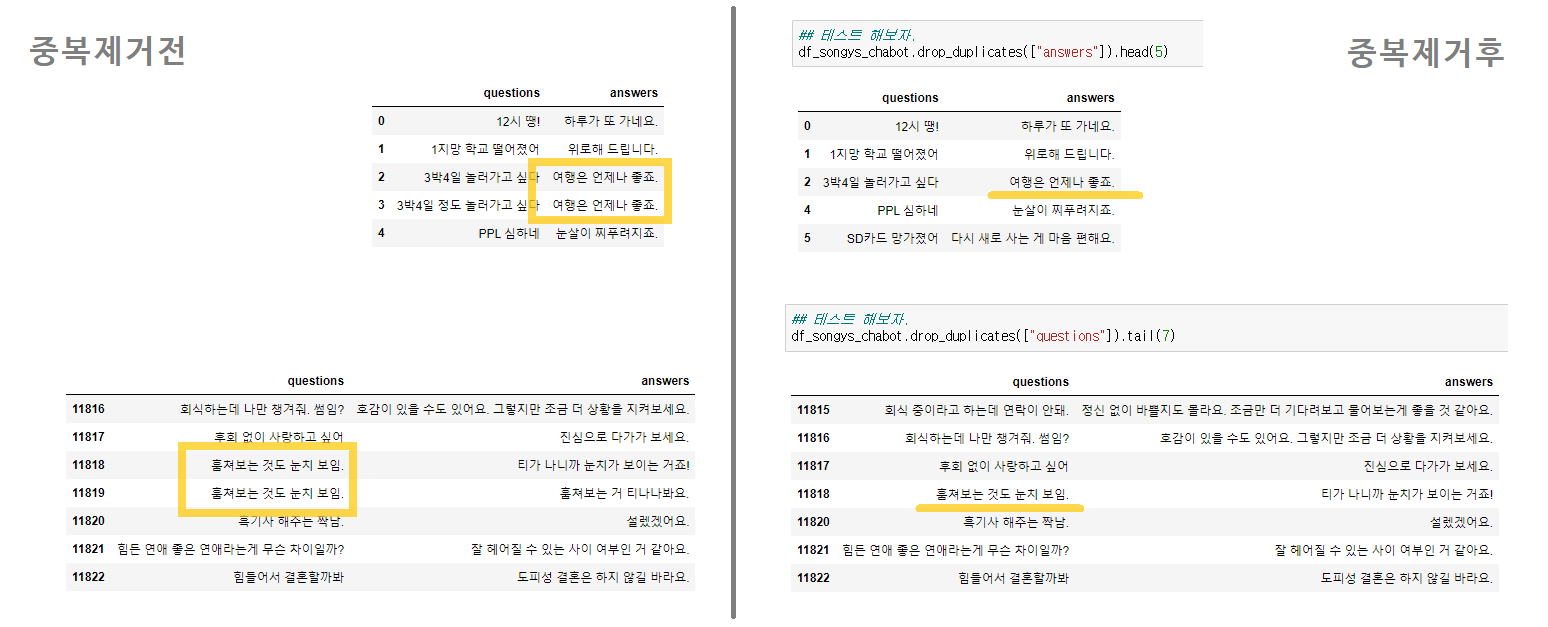

소스, 타겟 각자대로 중복제거 진행한 결과를 확인 할 수 있다.

아래는 각각의 코드를 수행했을 때에 예상되는 수치이다.

In [17]:
print("df_songys_chabot 전체 :", df_songys_chabot.shape)
print("df_songys_chabot【questions】중복 :", df_songys_chabot[df_songys_chabot["questions"].duplicated()].shape)
print("df_songys_chabot【answers】중복 :", df_songys_chabot[df_songys_chabot["answers"].duplicated()].shape)
print("df_songys_chabot【questions】중복제거후 예상 :", df_songys_chabot[~df_songys_chabot["questions"].duplicated()].shape)
print("df_songys_chabot【answers】중복제거후 예상 :", df_songys_chabot[~df_songys_chabot["answers"].duplicated()].shape)

df_songys_chabot 전체 : (11823, 2)
df_songys_chabot【questions】중복 : (162, 2)
df_songys_chabot【answers】중복 : (4044, 2)
df_songys_chabot【questions】중복제거후 예상 : (11661, 2)
df_songys_chabot【answers】중복제거후 예상 : (7779, 2)


실제 중복제거를 수행한다.

In [18]:
df_songys_chabot.drop_duplicates(["answers"], inplace=True)
df_songys_chabot.drop_duplicates(["questions"], inplace=True)

In [19]:
## 전체 테이터를 확인해보자
df_songys_chabot.shape

(7727, 2)

결측치가 있을 수도 있다. 확인해보자.

In [20]:
print("df_songys_chabot 전체 :", df_songys_chabot.shape)
print("df_songys_chabot【questions】결측 :", df_songys_chabot[df_songys_chabot["questions"].isnull()].shape)
print("df_songys_chabot【answers】결측 :", df_songys_chabot[df_songys_chabot["answers"].isnull()].shape)
print("df_songys_chabot【questions】결측제거후 예상 :", df_songys_chabot[~df_songys_chabot["questions"].isnull()].shape)
print("df_songys_chabot【answers】결측제거후 예상 :", df_songys_chabot[~df_songys_chabot["answers"].isnull()].shape)

df_songys_chabot 전체 : (7727, 2)
df_songys_chabot【questions】결측 : (0, 2)
df_songys_chabot【answers】결측 : (0, 2)
df_songys_chabot【questions】결측제거후 예상 : (7727, 2)
df_songys_chabot【answers】결측제거후 예상 : (7727, 2)


결측치는 없는 것으로 확인된다.

&nbsp;

어느정도 전처리 상태를 확인 했으니, 이제 데이터 순서를 지킬 필요가 없다. 

데이터를 섞어 준다.

In [21]:
# shuffling하고 index reset
df_songys_chabot = df_songys_chabot.sample(frac=1).reset_index(drop=True)

&nbsp;

다음에 수행해야 할 단계는 아래와 같다.

### ■ 전처리 → 중복제거 → **`토큰화`** → 어그멘테이션 → 스타트 엔드 토큰 넣고 → 정수인코딩 (벡터화)

일단 Step.3 으로 넘어가보자.

&nbsp;

### Step 3. 데이터 토큰화

<hr>

토큰화에는 ***KoNLPy***의 `mecab` 클래스를 사용합니다.



아래 조건을 만족하는 `build_corpus()` 함수를 구현하세요!




1. **소스 문장 데이터**와 **타겟 문장 데이터**를 입력으로 받습니다.


2. 데이터를 앞서 정의한 `preprocess_sentence()` 함수로 **정제하고, 토큰화**합니다.


3. 토큰화는 **전달받은 토크나이즈 함수를 사용**합니다. 이번엔 **`mecab.morphs`** 함수를 전달하시면 됩니다.


4. 토큰의 개수가 일정 길이 이상인 문장은 **데이터에서 제외**합니다.


5. **중복되는 문장은 데이터에서 제외**합니다. **`소스 : 타겟`** 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 `questions` 와 `answers` 를 각각 `que_corpus , ans_corpus` 에 토큰화하여 저장합니다.



&nbsp;

프로젝트 가이드에 따르면, 전처리의 경우 이전 단계에서 수행을 마친 상태이다.

Step.3 에서 ***KoNLPy***의 `mecab` 클래스를 사용하여 토큰화를 수행하는 것은 이번 스텝에서 진행하도록 하겠다.

현재 진행 상태는 아래와 같다.

### ■ 전처리 → 중복제거 → **`토큰화`** → 어그멘테이션 → 스타트 엔드 토큰 넣고 → 정수인코딩 (벡터화)

토큰화를 수행하자. tokenize() 함수를 정의할까 싶어서 생각해 봤다.

그런데, 이걸 정의하려고 보니, 어그멘테이션과 스타트 엔드 토큰 들어가는 부분도 필요하다.

In [22]:
def tokenize(corpus):
    
    mecab = Mecab()
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

    corpus = [mecab.morphs(sentence) for sentence in corpus]

    
    ## 어그멘테이션
    
    
    ## 스타트엔드토큰


    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


토큰화는 우선 일부분만 진행하고, 어그멘테이션 부분을 구현하도록 하자.

In [23]:
## 샘플 출력
df_songys_chabot.head(10)

,questions,answers
0,나쁜 사람인 걸 아는데도 좋아하는 마음이 사라지지 않아.,나쁜 사람일수록 끌리기도 하죠.
1,한약 너무 써,입에 쓴 게 몸에는 좋을 거예요.
2,이것도 제 미련이겠죠?,고민한다면 미련일 수 있어요.
3,아프고 또 아프지만,아스피린 한 알 먹어보세요.
4,짝남이 너무 좋은데 패션센스가 별로야.,패션은 사귀고 나서 바꿔줘도 돼요.
5,피부 관리해야지,투자한 만큼 거둘 수 있을 거예요!
6,이제 일주일,충분히 극복해낼 수 있어요.
7,이러지 말자,그 말씀 꼭 지키기 바랄게요.
8,전 여친 생일이야,이제 그냥 일년 중 하루로 지내요.
9,치매이면 어쩌지,무서운 소리 마세요.


In [24]:
## 토큰화와 어그멘테이션에 앞서 우선 형태소 분리만 수행하도록 하겠다.
mecab = Mecab()

df_songys_chabot["questions"] = df_songys_chabot["questions"].apply(lambda x: " ".join(mecab.morphs(x)))
df_songys_chabot["answers"] = df_songys_chabot["answers"].apply(lambda x: " ".join(mecab.morphs(x)))

df_songys_chabot.head(10)

,questions,answers
0,나쁜 사람 인 걸 아 는 데 도 좋 아 하 는 마음 이 사라지 지 않 아 .,나쁜 사람 일수록 끌리 기 도 하 죠 .
1,한약 너무 써,입 에 쓴 게 몸 에 는 좋 을 거 예요 .
2,이것 도 제 미련 이 겠 죠 ?,고민 한다면 미련 일 수 있 어요 .
3,아프 고 또 아프 지만,아스피린 한 알 먹 어 보 세요 .
4,짝 남 이 너무 좋 은데 패션 센스 가 별로 야 .,패션 은 사귀 고 나 서 바꿔 줘도 돼요 .
5,피부 관리 해야지,투자 한 만큼 거둘 수 있 을 거 예요 !
6,이제 일 주일,충분히 극복 해낼 수 있 어요 .
7,이러 지 말 자,그 말씀 꼭 지키 기 바랄게요 .
8,전 여친 생일 이 야,이제 그냥 일 년 중 하루 로 지내 요 .
9,치매 이 면 어쩌 지,무서운 소리 마세요 .


### ■ 전처리 → 중복제거 → 토큰화 → **`어그멘테이션`** → 스타트 엔드 토큰 넣고 → 정수인코딩 (벡터화)

&nbsp;

### Step 4. Augmentation

<hr>

우리에게 주어진 데이터는 **1만 개가량으로 적은 편**에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? **Lexical Substitution을 실제로 적용**해 보도록 하겠습니다.

아래 링크를 참고하여 **한국어로 사전 훈련된 Embedding 모델을 다운로드**합니다. `Korean (w)` 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 `Korean (w)` 를 찾아 다운로드하고, `ko.bin` 파일을 얻으세요!

- [Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 **데이터를 Augmentation** 하세요! 앞서 정의한 `lexical_sub()` 함수를 참고하면 도움이 많이 될 겁니다.



*Augmentation된 `que_corpus` 와 원본 `ans_corpus` 가 병렬을 이루도록, 이후엔 반대로 원본 `que_corpus` 와<br>Augmentation된 `ans_corpus` 가 병렬을 이루도록 하여 **전체 데이터가 원래의 3배가량으로 늘어나도록** 합니다.*



&nbsp;

아래의 코드를 실행 할 경우 오류메시지를 확인할 수 있다.

### `Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>`

- [gensim Vocab 로드 오류 해결하기](https://iambeginnerdeveloper.tistory.com/41)

미리 gensim  버전을 내려주어야 한다.

In [25]:
!pip install --upgrade gensim==3.8.3

In [26]:
print(gensim.__version__)

3.8.3


In [27]:
## Load PreTrained Korean Embedding Model

## 직접 다운로드 링크
## "https://drive.google.com/uc?export=download&id=0B0ZXk88koS2KbDhXdWg1Q2RydlU&confirm=yes"

ko_w2v = tf.keras.utils.get_file(
    os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ko.zip",
    origin="https://drive.google.com/uc?export=download&id=0B0ZXk88koS2KbDhXdWg1Q2RydlU&confirm=yes",
    extract=True, cache_subdir="/data/")

w2v_path = "/data/ko.bin"
w2v = gensim.models.Word2Vec.load(w2v_path)
type(w2v)

gensim.models.word2vec.Word2Vec

불러온 모델을 테스트해보자.

In [28]:
w2v.most_similar("포도")

/tmp/ipykernel_382/468656562.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar("포도")


[('딸기', 0.7215752601623535),
 ('사탕무', 0.6981558203697205),
 ('복숭아', 0.6955955624580383),
 ('참깨', 0.6662256121635437),
 ('고구마', 0.6647557020187378),
 ('옥수수', 0.6639925241470337),
 ('땅콩', 0.6633952856063843),
 ('벼', 0.6594249606132507),
 ('양배추', 0.6584994196891785),
 ('귀리', 0.657525360584259)]

In [29]:
w2v.most_similar("민트")

/tmp/ipykernel_382/2533396044.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar("민트")


[('핑거', 0.6945439577102661),
 ('쿠키', 0.6922162771224976),
 ('캔디', 0.6658134460449219),
 ('바닐라', 0.6654531359672546),
 ('레몬', 0.6637237668037415),
 ('브레드', 0.6599413156509399),
 ('머핀', 0.6582386493682861),
 ('솔리드', 0.6522738933563232),
 ('바나나', 0.6511702537536621),
 ('밀크', 0.6466017961502075)]

주어진 데이터를 토큰 단위로 분리한 후, 랜덤하게 하나를 선정하여 해당 토큰과 가장 유사한 단어를 찾아 대치하는 것으로 Lexical Substitution 을 확인해 볼 수 있다.

In [30]:
sample_sentence = "너의 공격 패턴을 알아냈다."
sample_sentence = preprocess_sentence(sample_sentence)
sample_sentence = " ".join(mecab.morphs(sample_sentence))
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += w2v.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

From: 너 의 공격 패턴 을 알아냈 다 .
To: 너 인의 공격 패턴 을 알아냈 다 . 


/tmp/ipykernel_382/2413301009.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  result += w2v.most_similar(tok)[0][0] + " "


입력된 문장을 Embedding 유사도를 기반으로 Augmentation 하여 반환하는 `lexical_sub()` 을 구현한다.

In [31]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from:
            res += _to + " "
        else:
            res += tok + " "

    return res

Augmentation 을 수행하자.

arg_proc 함수는 기본적으로 데이터 증강(어그멘테이션)을 수행한다.

세번째 is_ans_augment 인자에 True 를 지정하는 경우, answers 열의 값에 대한 증강을 수행한다.

기본 값은 questions 열의 값에 대한 데이터 증강을 수행한다.

In [32]:
## 빈 데이터 프레임 만들기

def arg_proc(df:pd.DataFrame, wv:gensim.models.word2vec.Word2Vec, is_ans_augment=False):

    ## Default
    go_aug = "questions"
    no_aug = "answers"
    
    if (is_ans_augment):
        go_aug, no_aug = no_aug, go_aug    ## SWAP
    
    ## NewDataFrame
    df_augment = pd.DataFrame(columns=["questions","answers"])
    
    for i in tqdm(range(0, df.shape[0])):
        row = df.iloc[i]

        ## row[go_arg]
        ## row[no_arg]
            
        goauged = lexical_sub(row[go_aug], wv)    ## Augmentation
        noauged = row[no_aug]
        
        ## Augmentation 결과 있을 경우, 추가
        if goauged is not None:
            df_augment = df_augment.append({go_aug:goauged, no_aug:noauged}, ignore_index=True)
        
        ## Augmentation 결과와 상관없이, 원본을 추가
        ## Augmentation 결과 있을 경우, Aug 결과와 원본 결과 추가되므로 값이 1건 늘어난 셈.
        df_augment = df_augment.append({go_aug:row[go_aug], no_aug:noauged}, ignore_index=True)
        
    
    return df_augment


Augmentation 을 실행해서 새로운 데이터프레임을 얻도록 하자.

In [33]:
## Warning 무시
import warnings
warnings.filterwarnings("ignore")

In [34]:
df_auged = arg_proc(df_songys_chabot, w2v)                  ## questions 컬럼에서 증강 수행
df_auged = arg_proc(df_auged, w2v, is_ans_augment=True)    ## answers 컬럼에서 증강 수행
print("✔️")

  0%|          | 0/7727 [00:00<?, ?it/s]

  0%|          | 0/14334 [00:00<?, ?it/s]

✔️


In [35]:
df_auged.shape

(27007, 2)

In [36]:
df_auged.sample(15)

,questions,answers
4054,간통 극복 시키 는 방법,이혼 하 세요 .
3526,짝 남 일 년 째이 멀리서 지켜보 기 만 하 는 중 .,뒤 에서 지켜 만 보 는 고충 이해 되 네요 .
13960,이벤트 안 하 는 남자 친구,먼저 이벤트 를 해 보 세요 .
12945,여자 연인 가 애교 많 았 으면 좋 겠 어,스스로 애교 를 부려 보 세요 .
18114,결국 놓아줬 카나,놓 느라 고생 했 어요 .
25540,참 소박 하 고 완벽 했 던 사람 .,좋 은 사람 이 었 나 봐요 .
23311,한 사람 만 죽 을 때 까지 사랑 할 가능성 있 을까 ?,가능 해요 !
19613,조카 오 는 것 싫 어,방문 열 어 주 지 마세요 는데
11465,이런 나 를 좋아해 주 는 사람 이 있 을까 ?,당신 은 정말 멋진 사람 이 에요 . 깍 아 내리 지 마세요 .
1388,헤어지 자 말 한 사람 도 힘들 까 ?,힘들 겠 지요 .


In [37]:
df_auged.tail(15)

,questions,answers
26992,휴 결국 헤어졌 습니다,마음 이 착잡 하 겠 어요 .
26993,원래 장난 도 잘 하 고 재밌 다고 들 시키 는데 그녀 앞 에선 작아지 는데 어떡 ...,짝사랑 앞 에서 누구 나 한 없이 작아지 나 봐요 는데 자신감 을 가지 세요 는데
26994,원래 장난 도 잘 하 고 재밌 다고 들 시키 는데 그녀 앞 에선 작아지 는데 어떡 ...,짝사랑 앞 에서 누구 나 한 없이 작아지 나 봐요 . 자신감 을 가지 세요 .
26995,원래 장난 도 잘 하 고 재밌 다고 들 하 는데 그녀 앞 에선 작아지 는데 어떡 해 .,짝사랑 앞 에서 누구 나 한 없이 작아지 나 봐요 . 자신감 을 갖 세요 .
26996,원래 장난 도 잘 하 고 재밌 다고 들 하 는데 그녀 앞 에선 작아지 는데 어떡 해 .,짝사랑 앞 에서 누구 나 한 없이 작아지 나 봐요 . 자신감 을 가지 세요 .
26997,너 한테 또 안 보낼 편지,못가 보낼 편지 쓰 지 마요 .
26998,너 한테 또 안 보낼 편지,안 보낼 편지 쓰 지 마요 .
26999,안주 뭐 먹 을까요 ?,살 안 찌 는 게 좋 를 것 같 아요 .
27000,안주 뭐 먹 을까요 ?,살 안 찌 는 게 좋 을 것 같 아요 .
27001,안주 뭐 먹 을까 ?,살 안 시루 는 게 좋 을 것 같 아요 .


목표 데이터 까지 값이 부족하다.

그리고 가이드에 따른 방법은 questions 먼저 수행하게 되면 question 이 2배수가 될 경우

뒤이어서 answers 의 증강을 수행 할 경우 answerw 에서는 4배수를 증강하게 되는 경우가 있는 것 같다.

그러므로 기존 함수의 내용을 조금 변경을 하여, 다시 만들도록 하겠다.

arg_proc_v2 함수는 questions, answers 컬럼을 한번에 어그멘테이션 하므로,

중복 데이터의 균형이 깨지는 사태를 더 방지할 수 있을 것이다.

In [38]:
def arg_proc_v2(df:pd.DataFrame, wv:gensim.models.word2vec.Word2Vec):

    ## NewDataFrame
    df_augment = pd.DataFrame(columns=["questions","answers"])
        
    for i in tqdm(range(0, df.shape[0])):
        row = df.iloc[i]

        ## row[go_arg]
        ## row[no_arg]
            
        q_aug = lexical_sub(row["questions"], wv)    ## Augmentation
        a_aug = lexical_sub(row["answers"], wv)    ## Augmentation
        
        ## Augmentation 결과 모두 있을 경우, 추가
        if (q_aug is not None) and (a_aug is not None):    ## 모두 증강 성공
#             df_augment = df_augment.append({"questions":q_aug+"ⓘ", "answers":a_aug+"ⓘ"}, ignore_index=True)    ## 테스트
            df_augment = df_augment.append({"questions":q_aug, "answers":a_aug}, ignore_index=True)
        elif (q_aug is not None) and (a_aug is None):    ## questions 만 증강 성공
#             df_augment = df_augment.append({"questions":q_aug+"ⓘ", "answers":row["answers"]}, ignore_index=True)    ## 테스트
            df_augment = df_augment.append({"questions":q_aug, "answers":row["answers"]}, ignore_index=True)
        elif (q_aug is None) and (a_aug is not None):    ## answers 만 증강 성공
#             df_augment = df_augment.append({"questions":row["questions"], "answers":a_aug+"ⓘ"}, ignore_index=True)    ## 테스트
            df_augment = df_augment.append({"questions":row["questions"], "answers":a_aug}, ignore_index=True)
        
        ## Augmentation 결과와 상관없이, 원본을 추가
        ## Augmentation 결과 있을 경우, Aug 결과와 원본 결과 추가되므로 값이 1건 늘어난 셈.
        df_augment = df_augment.append({"questions":row["questions"], "answers":row["answers"]}, ignore_index=True)
        
    
    return df_augment

변경된 함수로 증강을 중첩하여 다시 실행하자.

In [39]:
print("[0/2] df_songys_chabot.shape", df_songys_chabot.shape)
df_auged = arg_proc_v2(df_songys_chabot, w2v)    ## 1st aug
print("[1/2] df_auged.shape", df_auged.shape)
df_auged = arg_proc_v2(df_auged, w2v)            ## 2nd aug
print("[2/2] df_auged.shape", df_auged.shape)
print("✔️")

[0/2] df_songys_chabot.shape (7727, 2)


  0%|          | 0/7727 [00:00<?, ?it/s]

[1/2] df_auged.shape (15317, 2)


  0%|          | 0/15317 [00:00<?, ?it/s]

[2/2] df_auged.shape (30355, 2)
✔️


In [40]:
df_auged.sample(8)

,questions,answers
2140,커플 여행 가 면 잘 싸워 ?,연애 초면 싸우 기 도 하 는 거 같 아요 .
1834,기분 그러 그지 같 아,신나 는 음악 들 어 살펴보 세요 .
19322,첫눈 오 는 날 만나 고 겠 다,이런 사람 이 있 다니 부럽 네요 .
10008,기념일 또 까먹 었 어,달력 에 적 어 보 세요 .
17602,헤어지 꼼짝 열흘 짼데 너무 힘드 네,헤어지 고 있 는 중의 이 시 군요 .
22555,고독 한 밤,혼자 가 아니 에요 .
27000,훔쳐 보 ㄴ다는 것 도 눈치 보임 .,디 가 나 니까 눈치 가 보이 는 거 죠 !
9593,감정싸움 그만 시키 고 싶 어,자존심 을 세우 지 마세요 는데


In [41]:
df_auged.tail(16)

,questions,answers
30339,원래 장난 도 잘 하 고 재밌 다고 들 하 는데 그녀 앞 에선 짧아지 는데 어떡 해...,짝사랑 앞 에서 누구 나 한 없이 작아지 나 봐요 . 자신감 를 갖 세요 .
30340,원래 장난 도 잘 하 고 재밌 다고 들 하 는데 그녀 앞 에선 작아지 는데 어떡 해...,짝사랑 앞 에서 누구 나 한 없이 작아지 나 봐요 . 자신감 을 갖 세요 .
30341,본래 장난 도 잘 하 고 재밌 다고 들 하 는데 그녀 앞 에선 작아지 는데 어떡 해 .,짝사랑 옆 에서 누구 나 한 없이 작아지 나 봐요 . 자신감 을 가지 세요 .
30342,원래 장난 도 잘 하 고 재밌 다고 들 하 는데 그녀 앞 에선 작아지 는데 어떡 해 .,짝사랑 앞 에서 누구 나 한 없이 작아지 나 봐요 . 자신감 을 가지 세요 .
30343,너 한테 또 안 보낼 편지,안 보낼 서신 읽 지 마요 .
30344,너 에게 또 안 보낼 편지,안 보낼 편지 읽 지 마요 .
30345,너 한테 또 안 보낼 서신,안 보낼 편지 쓰 지 마요 .
30346,너 한테 또 안 보낼 편지,안 보낼 편지 쓰 지 마요 .
30347,의주 ... 먹 을까 ?,살 안 찌 는 게 좋 을 것 같 아요 .
30348,안주 ... 먹 을까 ?,살 안 찌 는 게 괜찮 을 것 같 아요 .


원본 데이터 의 약 4배가 되었고, questions 와 answers 각각 증강이 골고루 적용된 것을 확인 할 수 있다.

이론상 중복이 발생했더라도 많이는 발생하지 않았을 것이다. 혹시 모르니 한번 확인 해 보자.

In [42]:
print("df_auged 전체 :", df_auged.shape)
print("df_auged 중복 :", df_auged[df_auged.duplicated()].shape)
print("df_auged 중복제거후 예상 :", df_auged[~df_auged.duplicated()].shape)

df_auged 전체 : (30355, 2)
df_auged 중복 : (222, 2)
df_auged 중복제거후 예상 : (30133, 2)


In [43]:
df_auged.drop_duplicates(inplace=True)    ## 중복제거
df_auged.reset_index(inplace=True)    ## 인덱스 초기화
df_auged.shape

(30133, 3)

&nbsp;

이제, 이전에 진행하려다가 못한 토큰화 부분부터 다시 진행하도록 하자.

### ■ 전처리 → 중복제거 → 어그멘테이션 → **`토큰화`** (스타트 엔드 토큰) → 벡터화

&nbsp;

### ▶ 현재 진행상태는 아래와 같다.



~~1. **소스 문장 데이터**와 **타겟 문장 데이터**를 입력으로 받습니다.~~


~~2. 데이터를 앞서 정의한 `preprocess_sentence()` 함수로 **정제하고, 토큰화**합니다.~~


3. 토큰화는 **전달받은 토크나이즈 함수를 사용**합니다. 이번엔 **`mecab.morphs`** 함수를 전달하시면 됩니다.


4. 토큰의 개수가 일정 길이 이상인 문장은 **데이터에서 제외**합니다.


~~5. **중복되는 문장은 데이터에서 제외**합니다. **`소스 : 타겟`** 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!~~

어그멘테이션은 이전에 다 마친 상태의 데이터이다.

토큰길이 제한을 위해 잠시 토큰화를 적용하자.

In [44]:
df_auged_tok = pd.DataFrame(columns=["questions","answers"])
df_auged_tok["questions"] = df_auged["questions"].apply(lambda x: mecab.morphs(x))
df_auged_tok["answers"] = df_auged["answers"].apply(lambda x: mecab.morphs(x))
df_auged_tok.sample(5)

,questions,answers
11013,"[내, 친구, 랑, 내, 짝, 녀, 가, 서로, 좋아하, 는, 것, 같, 은데, 나...","[천천히, 마음, 을, 계산, 하, 는, 게, 필요, 하, 겠, 어요, .]"
8793,"[또, 전화, 안, 넘겨, 받, 아]","[조금, 기다리, 면, 풀릴, 것, 예요]"
13153,"[힘듭니다, .]","[어떤, 말, 도, 위, 로, 가, 되, 지, 않, 겠, 지만, 힘내, 세요, .]"
18984,"[썸, 그러, 었, 으면, 좋, 싶, 어]","[그리워, 하, 인지, 생각, 해, 살펴보, 세요, .]"
13004,"[여자, 친구, 코, 완전, 높, 아]","[멋진, 젊은이, 이랑, 사귀, 어서, 좋, 겠, 네요, .]"


In [45]:
len(df_auged_tok)

30133

In [46]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수

q, a = [], []

q.clear()
a.clear()

for i in tqdm(range(len(df_auged_tok))):
    q.append(df_auged_tok["questions"][i])
    a.append(df_auged_tok["answers"][i])

print('전체 샘플 수 :', len(q))
print('전체 샘플 수 :', len(a))

  0%|          | 0/30133 [00:00<?, ?it/s]

전체 샘플 수 : 30133
전체 샘플 수 : 30133


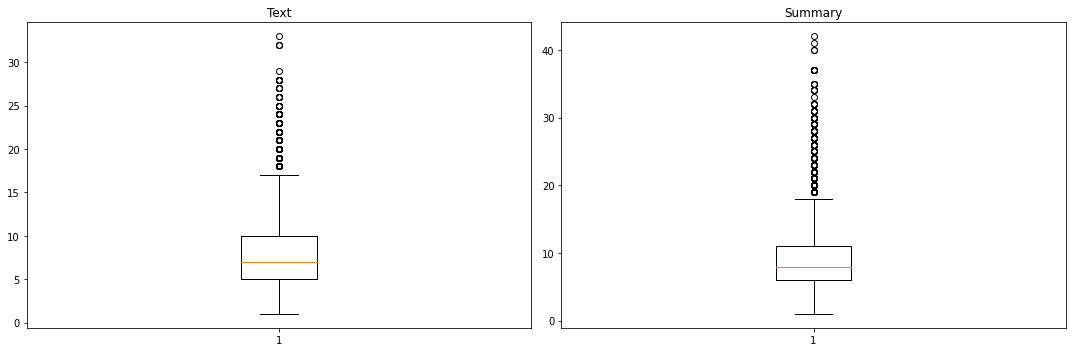

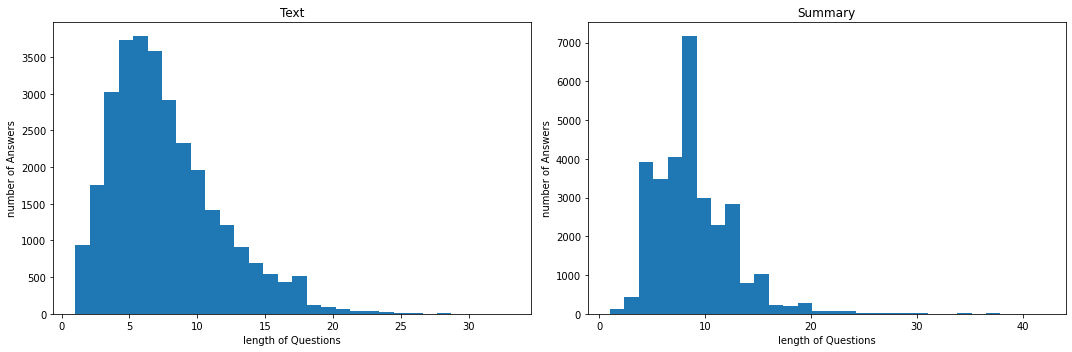

물음 최소 길이 : 1
물음 최대 길이 : 33
물음 평균 길이 : 7.743171937742674
답변 최소 길이 : 1
답변 최대 길이 : 42
답변 평균 길이 : 8.903660438721667


In [47]:
## 테스트 ────────────────────────────────────────────────

# 길이 분포 출력
q_len = [len(s) for s in q]
a_len = [len(s) for s in a]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.boxplot(q_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(a_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Text')
plt.hist(q_len, bins = 30)
plt.xlabel('length of Questions')
plt.ylabel('number of Answers')
plt.subplot(1,2,2)
plt.title('Summary')
plt.hist(a_len, bins = 30)
plt.xlabel('length of Questions')
plt.ylabel('number of Answers')
plt.tight_layout()
plt.show()

print('물음 최소 길이 : {}'.format(np.min(q_len)))
print('물음 최대 길이 : {}'.format(np.max(q_len)))
print('물음 평균 길이 : {}'.format(np.mean(q_len)))
print('답변 최소 길이 : {}'.format(np.min(a_len)))
print('답변 최대 길이 : {}'.format(np.max(a_len)))
print('답변 평균 길이 : {}'.format(np.mean(a_len)))



## 테스트 ────────────────────────────────────────────────

적당한 길이를 선택하여 제한을 하도록 하자.

In [48]:
MAX_TOK_LEN = 25

In [49]:
que_corpus, ans_corpus = [], []

que_corpus.clear()
ans_corpus.clear()

for i in tqdm(range(len(df_auged_tok))):
    if ((len(df_auged_tok["questions"][i]) < MAX_TOK_LEN) and (len(df_auged_tok["answers"][i]) < MAX_TOK_LEN)):
        que_corpus.append(df_auged_tok["questions"][i])
        ans_corpus.append(df_auged_tok["answers"][i])
        

  0%|          | 0/30133 [00:00<?, ?it/s]

In [50]:
print(len(df_auged_tok))
print(len(que_corpus))
print(len(ans_corpus))

30133
29983
29983


약간의 데이터가 제외된 것을 확인할 수 있다.

다시 데이터프레임으로 합친다.

In [51]:
df_cleaned = pd.DataFrame(data=[que_corpus, ans_corpus], index=["questions", "answers"]).T

df_cleaned["questions"] = df_cleaned["questions"].apply(lambda x: " ".join(x))
df_cleaned["answers"] = df_cleaned["answers"].apply(lambda x: " ".join(x))

print(df_cleaned.shape)
df_cleaned.sample(10)

(29983, 2)


,questions,answers
11746,제 가 좋 아 하 던 사람 이 절 좋 아 하 ㄴ다면 갑자기 거부 감 들 고 싫 어 ...,어떤 트라우마 가 있 었 는지 도 모르 겠 는데요 .
28345,짝사랑 끝내 고 나 의 니 마음 이 공허 하 다 .,사랑 했 던 시간 이 멈춰 버려서 이런 거 예요 .
19091,아무래도 우울증 걸린 거 같 아,마음 의 병 이 조금 씩 나아지 길 바랍니다 .
6361,여자 친구 가 연락 이 안 돼,별일 없 를 거 예요 .
13978,나 누락 됐 나 봐,입증 해 달 라고 해 보 세요 는데
20093,이유 라는 게 뭔지,알 다가 도 모를 .
6572,위생 검진 왔 어서,넘 기 의식 적 으로 해 주 는 게 좋 죠 .
23472,내 가치관 이랑 다른 가치관 을 가지 고 있 는 그 남자 를 싫어하 는 게 힘들 어 는데,서로 의 사고방식 그러 평행선 을 이루 지만 않 는다면 만날 수 도 있 을 거 예요 .
21416,여자 는 호감 없 어도 잘 해 줘 ?,본래 성격 이 그럴 수 도 있 어요 .
7866,몇 반 될지 궁금 해,잘 되 길 바랍니다 .


&nbsp;

### ▶ 현재 진행상태는 아래와 같다.



~~1. **소스 문장 데이터**와 **타겟 문장 데이터**를 입력으로 받습니다.~~


~~2. 데이터를 앞서 정의한 `preprocess_sentence()` 함수로 **정제하고, 토큰화**합니다.~~


~~3. 토큰화는 **전달받은 토크나이즈 함수를 사용**합니다. 이번엔 **`mecab.morphs`** 함수를 전달하시면 됩니다.~~


~~4. 토큰의 개수가 일정 길이 이상인 문장은 **데이터에서 제외**합니다.~~


~~5. **중복되는 문장은 데이터에서 제외**합니다. **`소스 : 타겟`** 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!~~

Step 3 의 과정은 이렇게 마무리 지었고, Step 4. Augmentation 은 이전에 수행한 상태이다. Step 5. 로 넘어가자.

&nbsp;

### Step 5. 데이터 벡터화

<hr>

타겟 데이터인 `ans_corpus` 에 `<start>` 토큰과 `<end>` 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 `ans_corpus` 는 `list` 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

In [52]:
sample_data = ["12", "시", "땡", "!"]

print(["<start>"] + sample_data + ["<end>"])

['<start>', '12', '시', '땡', '!', '<end>']


１. 위 소스를 참고하여 타겟 데이터 전체에 **`<start>`** 토큰과 **`<end>`** 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 **소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것**이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

２. 특수 토큰을 더함으로써 **`ans_corpus`** 또한 완성이 되었으니, **`que_corpus`** 와 결합하여 **전체 데이터에 대한 단어 사전을 구축**하고 **벡터화하여 `enc_train` 과 `dec_train`** 을 얻으세요!

&nbsp;

대부분의 내용을 하는김에 진행해 버린 것들이 많아서,

사실상 단어사전 구축과 벡터화를 통해 enc_train, dec_drain 작업이 남았다.

여기서도 하는김에 적은 비율로 enc_test, dec_test 까지 분리하는 작업을 진행하도록 하겠다.

In [53]:
print("df_cleaned 전체 :", df_cleaned.shape)
print("df_cleaned 중복 :", df_cleaned[df_cleaned.duplicated()].shape)
print("df_cleaned 중복제거후 예상 :", df_cleaned[~df_cleaned.duplicated()].shape)
df_cleaned.drop_duplicates(inplace=True)    ## 중복제거
df_cleaned.reset_index(inplace=True)    ## 인덱스 초기화

print()
print("df_cleaned.shape", df_cleaned.shape)

## 샘플 150개 추출하여 test 데이터로 사용
df_test = df_cleaned.sample(150)

## 전체 데이터셋에서 test 데이터를 차집합으로 제외하고, 나머지를 train 데이터로 사용.
df_train = pd.concat([df_cleaned, df_test, df_test]).drop_duplicates(keep=False)

print("df_test.shape", df_test.shape)
print("df_train.shape", df_train.shape)

df_cleaned 전체 : (29983, 2)
df_cleaned 중복 : (39, 2)
df_cleaned 중복제거후 예상 : (29944, 2)

df_cleaned.shape (29944, 3)
df_test.shape (150, 3)
df_train.shape (29794, 3)


이제 토큰화와 벡터화를 다시 진행하여야 한다.

토큰화 과정에서 타겟 데이터에 **`<start>`** 토큰과 **`<end>`** 토큰을 추가하고,

단어사전 구축 및 벡터화를 진행하여 enc_train, dec_train 을 얻어보자.

In [54]:
## 토큰화
df_data = pd.DataFrame(columns=["questions","answers"])
df_data["questions"] = df_train["questions"].apply(lambda x: mecab.morphs(x))
df_data["answers"] = df_train["answers"].apply(lambda x: ["<start>"] + mecab.morphs(x) + ["<end>"])
df_data.shape

(29794, 2)

In [55]:
df_data.reset_index(inplace=True)    ## 인덱스 초기화

df_data.sample(5)

,index,questions,answers
11779,11839,"[그리움, 만, 은, 데, 어쩔, 가능, 성, 없, 는가, 보, 다]","[<start>, 완전히, 잊, 는다는, 건, 증거, 불, 가능, 하, 니까요, 는..."
27656,27793,"[공시, 준비, 하, 는, 데, 연애, 하, ㄴ다면, 안, 되, 겠, 꼼짝, ?]","[<start>, 현재, 뭐, 가, 중요, 한지, 객관적으로, 생각, 해, 살펴보,..."
23759,23870,"[어, 장, 인, 것, 아, 는, 데, 도, 좋, 아, 해, .]","[<start>, 괴로움, 을, 접, 는, 게, 쉽, 진, 않, 아요, ., <end>]"
22095,22197,"[어둠, 아서, 끝, 나라]","[<start>, 빛, 이, 있, 를, 거, 예요, ., <end>]"
1598,1609,"[걷, 자고, 꼬셔]","[<start>, 살랑대, 는, 바람, 에, 마음, 도, 움직일, 거, 예요, .,..."


In [56]:
# enc_train, dec_train = [], []

# enc_train.clear()
# dec_train.clear()

# for i in tqdm(range(len(df_data))):
    
#     enc_train.append(df_data["questions"][i])
    
#     dec_train.append(df_data["answers"][i])

enc_data = list(df_data["questions"])
dec_data = list(df_data["answers"])

In [57]:
np.array(enc_data).shape

(29794,)

벡터화 하는 함수를 정의한다.

In [58]:
## <start> <end> 토큰 추가전에 미리 크기를 키워놓았다.
MAX_TOK_LEN = MAX_TOK_LEN + 2

In [59]:
def vectorize(enc_data, dec_data):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    
    tokenizer.fit_on_texts(enc_data)
    
    tokenizer.fit_on_texts(dec_data)

    
    enc_tensor = tokenizer.texts_to_sequences(enc_data)
    
    dec_tensor = tokenizer.texts_to_sequences(dec_data)
    

    enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, maxlen=MAX_TOK_LEN, padding='post')
    
    dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(dec_tensor, maxlen=MAX_TOK_LEN, padding='post')
    

    return enc_tensor, dec_tensor, tokenizer


벡터화 한다.

In [60]:
enc_train, dec_train, tok = vectorize(enc_data, dec_data)

In [61]:
enc_train.shape

(29794, 27)

In [62]:
dec_train.shape

(29794, 27)

In [63]:
print("len(tok.word_counts) :", len(tok.word_counts))

## padding 해서 0 이 추가.
VOCAB_SIZE = len(tok.word_counts) + 1
print("VOCAB_SIZE :", VOCAB_SIZE)

len(tok.word_counts) : 7625
VOCAB_SIZE : 7626


&nbsp;

### Step 6. 훈련하기

<hr>

앞서 번역 모델을 훈련하며 정의한 `Transformer` 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! **가장 멋진 답변**과 **모델의 하이퍼파라미터**를 제출하시면 됩니다.

~~~
# 예문
1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

---

# 제출

Translations
> 1. 잠깐 쉬 어도 돼요 . <end>
> 2. 맛난 거 드세요 . <end>
> 3. 떨리 겠 죠 . <end>
> 4. 좋 아 하 면 그럴 수 있 어요 . <end>

Hyperparameters
> n_layers: 1
> d_model: 368
> n_heads: 8
> d_ff: 1024
> dropout: 0.2

Training Parameters
> Warmup Steps: 1000
> Batch Size: 64
> Epoch At: 10
~~~

### ▶ Positional Encoding

In [63]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### ▶ Multi-Head Attention

In [64]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        """
        Scaled QK 값 구하기
        """
        
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        # scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
        if mask is not None:
            scaled_qk += (mask * -1e9)
            
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    
    def combine_heads(self, x):
        
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### ▶ Position-wise Feed-Forward Network

In [65]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### ▶ Encoder 레이어 구현하기

In [66]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### ▶ Decoder 레이어 구현하기

In [67]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### ▶ Encoder / Decoder 클래스 정의

In [68]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


포지셔널 인코딩 후 디코더 층을 $\text{num_layers}$의 개수만큼 쌓는 코드이다.

In [69]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        
        ## 디코더를 num_layers개 쌓기
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### ▶ Transformer 클래스 구현

In [70]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### ▶ Masking

In [71]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

#     print("seq >>", seq)
   
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


### ▶ Learning Rate 와 Optimizer

In [72]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


<hr>

모델설계가 끝났으니, 훈련을 진행한다.

In [74]:
## Hyperparameters
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.3
warmup_steps = 4000    ## default 4000
batch_size = 64        ##
epochs = 30

BATCH_SIZE = batch_size
EPOCHS = epochs

In [75]:
## Transformer
transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=64,
    dropout=dropout,
    shared=True)

In [76]:
# learning_rate = LearningRateScheduler(512, warmup_steps=4000)
learning_rate = LearningRateScheduler(512, warmup_steps=warmup_steps)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [77]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [78]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [79]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

#     pieces = src_tokenizer.encode_as_pieces(sentence)
#     tokens = src_tokenizer.encode_as_ids(sentence)

    pieces = mecab.morphs(sentence)
    
    tokens = []
    for s in pieces:
        tokens.append(src_tokenizer.word_index[s])
    
#     print(pieces)
#     print(tokens)
    

    _input = tf.keras.preprocessing.sequence.pad_sequences(
        [tokens],
        maxlen=enc_train.shape[-1],
        padding='post')
    
#     print(_input)
    
    ids = []
    
#     output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    output = tf.expand_dims([src_tokenizer.word_index["<start>"]], 0)
#     print("_input", _input)
#     print("output", output)

#     print(dec_train.shape[-1])
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

#         if tgt_tokenizer.eos_id() == predicted_id:
        if tgt_tokenizer.word_index["<end>"] == predicted_id:

#             result = tgt_tokenizer.decode_ids(ids)
            result = [tgt_tokenizer.index_word[i] for i in ids]
    
#             print("result_A", result)
            
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)
    
#     print("result_B", result)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [80]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, 
              src_tokenizer, tgt_tokenizer, 
              minimal=False):
    
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    
    if (minimal):
        result = " ".join(result)
        return result
    
    print("─" * 32)
    print()
    print('▷ Input                ：%s' % (sentence))
    print()
    print('▷ Predicted translation：{}'.format(result))
    print()

In [81]:
# 학습
from tqdm import tqdm_notebook 


examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    ## 15 epoch 이후부터 출력
    ## 그전 데이터들은 결과물이 좋지 못하다.
    if (epoch < 15):
        continue
    
    buff_exam = ""
    buff_tran = ""
    
    for i, example in enumerate(examples, start=1):
        buff_exam += str(i) + ". " + example + "\n"
        buff_tran += "> " + str(i)+". " + translate(
            example, transformer, tok, tok, minimal=True) + "\n"
        
    print("Examples")
    print()
    print(buff_exam)
    
    print("Translations")
    print()
    print(buff_tran)
    
    print()
    print("Hyperparameters")
    print("> " + "n_layers :", str(n_layers))
    print("> " + "d_model :", str(d_model))
    print("> " + "n_heads :", str(n_heads))
    print("> " + "d_ff :", str(d_ff))
    print("> " + "dropout :", str(dropout))
    print()
    
    print("Training Parameters")
    print("> " + "Warmup Steps :", str(warmup_steps))
    print("> " + "Batch Size :", str(batch_size))
    print("> " + "Epoch At :", str(epoch + 1))

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 많이 확실 한 의사 가 끝 의 의결 을 찾아보 세요 .
> 2. 그만큼 많 은 남자 연인 를 좀 좋 은 첫날 이 에요 .
> 3. 득템 했 구불구불 바랍니다 .
> 4. 저 도 요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 16


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 이별 에 도 요 .
> 2. 자연 스럽 도록 요 .
> 3. 떨리 죠 .
> 4. 대청소 를 해 보 세요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 17


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 도 같 나요 .
> 2. 푹 숀 세요 .
> 3. 득템 했 길 바랍니다 .
> 4. 대청소 를 해 보 네요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 18


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 공부 는 꿈 과 같 아요 .
> 2. 잠 이 최고 죠 .
> 3. 휴식 도 필요 해요 .
> 4. 알 기 에 젊은이 이 더 힘들 죠 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 19


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 많이 답답 하 신가 봐요 .
> 2. 푹 쉬 고 살 거 예요 .
> 3. 좋 은 데이트 를 두 고 없 어요 .
> 4. 준비 하 고 싶 네요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 20


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 가 있 을 거 예요 .
> 2. 술 한잔 에 답 이 날 거 예요 .
> 3. 떨리 죠 .
> 4. 예상 를 알 아 는 건 어떨까 요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 21


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 공부 열심히 하 고 신청 해 보 세요 .
> 2. 푹 쉬 세요 .
> 3. 좋 은 데이트 좋 은데요 .
> 4. 쉽 지 않 은 일 이 있 나 봐요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 22


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 많이 답답 한가요 는데
> 2. 잠 이 최고 죠 .
> 3. 떨리 네요 .
> 4. 나 한테 기대 ㅂ시오 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 23


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 도 월 과 이 에 대한 이야기 를 해 보 세요 .
> 2. 푹 쉬 고 을지 도 몰르 겠 어요 .
> 3. 점심 에 데이트 나 봐요 .
> 4. 저 도 안 좋 아 질 거 예요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 24


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 는 마음 이 글 로 해 보 세요 .
> 2. 그런 순간 이 올 거 예요 .
> 3. 떨리 겠 어요 .
> 4. 쉽 지 않 을 때 지만 시간 이 해결 해 줄 거 예요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 25


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 블 랑 같이 놀 은데요 .
> 2. 푹 숀 나 봐요 .
> 3. 휴식 을 취해 보 세요 .
> 4. 쉽 지 않 죠 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 26


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 는 바람 쉬 어도 돼요 .
> 2. 푹 쉬 고 좀 더 일찍 주무세요 .
> 3. 득템 해 의 보 세요 .
> 4. 쉽 게 나 아 지 않 을 때 를 일 것 예요 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 27


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 많이 답답 한가요 .
> 2. 자연 스럽 게 데이트 오자키 .
> 3. 휴식 을 취해 보 세요 .
> 4. 쉽 지 않 은 일 이 죠 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 28


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 블 랑 같이 살 아요 .
> 2. 자연 스럽 게 좀 더 조심 이 었 나 봐요 .
> 3. 점심 의 사랑 에 따라 다른 모습 을 보여 주 세요 .
> 4. 쉽 지 않 은 일 이 길 바랍니다 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 29


  0%|          | 0/466 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 저 ㄴ 다 는 어때요 ?
> 2. 자연 스럽 게 울 어도 괜찮 아 질 거 예요 .
> 3. 휴식 때문 필요 하 죠 .
> 4. 쉽 지 않 은 일 이 죠 .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 30


&nbsp;

모델의 훈련을 반복하면서, 예문에 대한 답변을 생성하고 어느정도 출력해보았다.

그나마 가장 멋진 답변과 모델의 하이퍼파라미터는 아래와 같다.

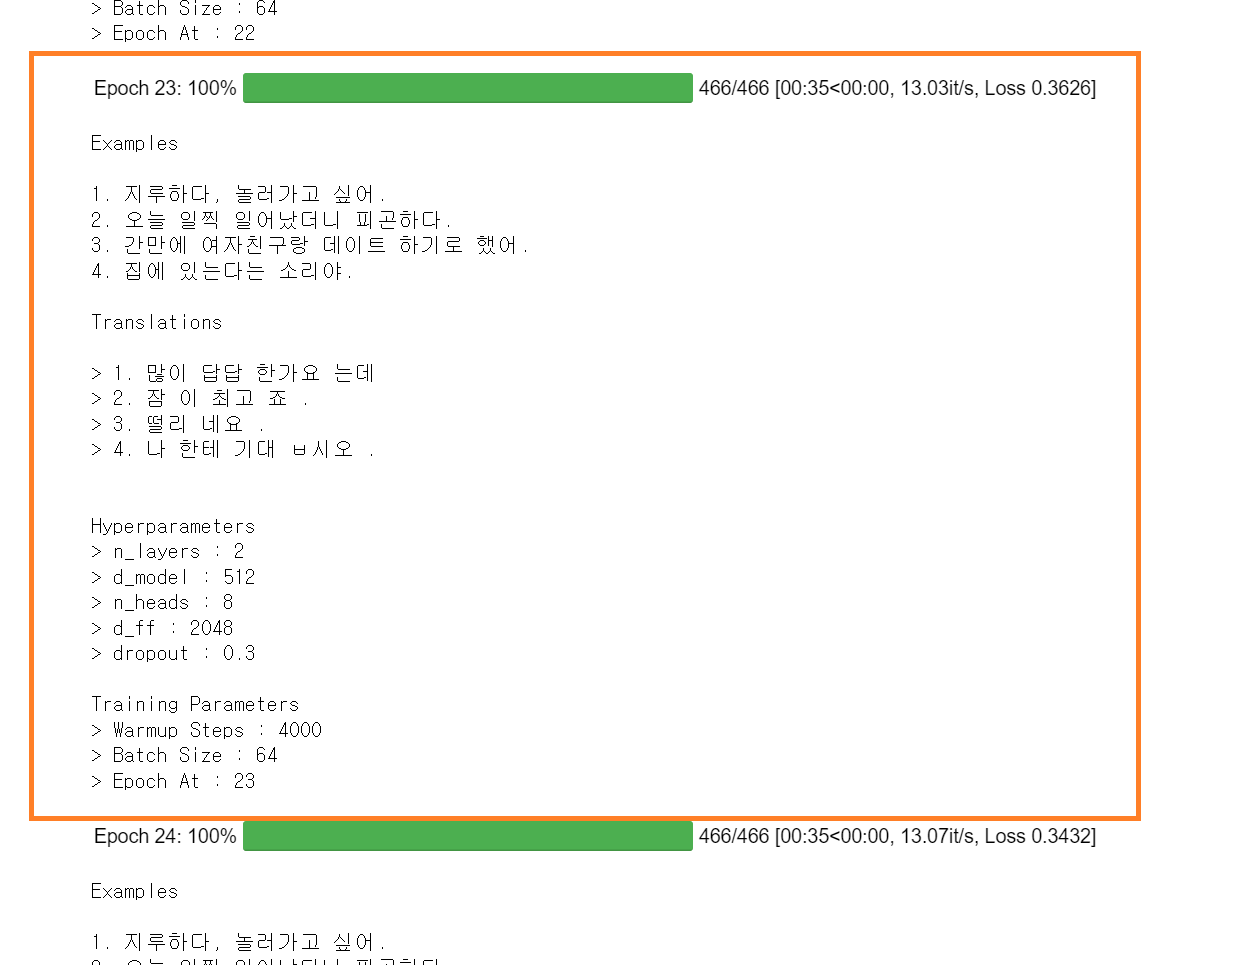

이번에도 그다지 만족스럽지 못한 결과이다.

형태소분석기와 데이터증강의 콤비네이션에 발목잡힌 느낌이다.

1. 의 맨 끝에 ＂는데＂라는 것은 데이터 증강 과정에서 생성된 단어라서, 잘 되긴 한데 완벽한 느낌은 아니라서 아깝다.

2. 의 경우는 그럭저럭 괜찮은 답변이다.

3. 의 경우는 떨리 네요… 뭐 괜찮은 답변인데, 증강하면서 삭제가 되기 전의 단어는 ＂떨리겠네요.＂ 일거라 예상된다.

4. 의 경우는 망한 답변이라고 생각된다.

&nbsp;

### Step 7. 성능 측정하기

<hr>

챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 `calculate_bleu()` 함수도 적용해 보세요.




&nbsp;

각 단어의 확률값을 계산하는 calc_prob() 함수를 구현한다.

In [82]:
# calc_prob() 구현
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns = \
    model(src_ids, tgt_ids, enc_padding_mask, combined_mask, dec_padding_mask)
            
    return tf.math.softmax(predictions, axis=-1)
print("✔️")

✔️


beam_search_decoder()는 Beam Search를 기반으로 동작한다.

In [99]:
def beam_search_decoder(
    sentence, src_len, tgt_len, model, 
    src_tokenizer, tgt_tokenizer, beam_size):
    
    ## 추가
    sentence = preprocess_sentence(sentence)    
    pieces = mecab.morphs(sentence)
    
    
#     tokens = src_tokenizer.encode_as_ids(sentence)
    tokens = []
    for s in pieces:
        tokens.append(src_tokenizer.word_index[s])
        
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences(
        [tokens], maxlen=src_len, padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

#     pred_tmp[:, 0] = tgt_tokenizer.bos_id()
    pred_tmp[:, 0] = src_tokenizer.word_index["<start>"]

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

#             if prediction[-1] == tgt_tokenizer.eos_id():
            if prediction[-1] == tgt_tokenizer.word_index["<end>"]:
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
#         zero_idx = long_pred.tolist().index(tgt_tokenizer.eos_id())
        zero_idx = long_pred.tolist().index(tgt_tokenizer.word_index["<end>"])
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred

BLEU 계산 함수

In [100]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu(
        [reference],
        candidate,
        weights=weights,
        smoothing_function=SmoothingFunction().method1)

print("✔️")

✔️


 beam_bleu()는 생성된 문장에 대한 BLEU Score를 계산해 출력한다.

In [120]:
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    
    for _id in ids:
#         candidate = tokenizer.decode_ids(_id.tolist()).split()
#         print("_id :", _id) 
#         ## _id : [  2 196   6  19 227  92 184 345 398   1   3]
#         print("_id.tolist() :", _id.tolist())    
#         ## _id.tolist() : [2, 196, 6, 19, 227, 92, 184, 345, 398, 1, 3]
        candidate = [tokenizer.index_word[i] for i in _id.tolist()]
    
        ## 추가 start, end 토큰 제거
        candidate = candidate[1:-1] 
        
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", round(calculate_bleu(reference, candidate), 4))

        total_score += score
        
    return total_score / len(ids)

구현 후 아래와 같이 사용한다.

In [89]:
print("df_test.shape", df_test.shape)
df_test.sample(5)


df_test.shape (150, 3)


,index,questions,answers
16202,16223,그렇게 오래 살 았 는데 때문 파악 를 못 하 겠 어,온전 한 파악 는 없 어요 는데
1179,1181,여자 친구 가 사진 을 너무 많이 찍 어 .,예쁘 게 많이 찍 어 주 세요 .
16087,16108,후폭풍 이 올까 두려운 데 는데 !,그냥 지금 우세요 .
24779,24811,그러 별후 6 개월,많 은 변화 가 뒤잇 었 겠 죠 는데
3661,3663,아직 도 널 감싸 는 내 가 싫 다 .,자신 도 따뜻 하 게 감싸 주 세요 .


In [90]:
enc_test = list(df_test["questions"])
dec_test = list(df_test["answers"])

지금까지의 내용을 정리하여 print_blue_score 로 묶어 놓았다.

샘플로 몇개 출력해 보기 위한 용도로 매개변수 헷갈리지 않도록 인덱스만 넣어 사용하도록 정리했다.

Beam Size의 경우. **`5`** 라고 가정하면…

1. 맨 첫 단어로 적합한 5개의 단어를 생성하고, 두 번째 단어로 각 첫 단어(5개 단어)에 대해<br>
 5순위까지 확률을 구하여 총 25개의 문장을 생성. 


2. 그 25개의 문장들은 각 단어에 할당된 확률을 곱하여 구한 점수(존재 확률) 를 가지고<br>
 각각의 순위를 매겨 점수 상위 5개의 표본만 세 번째 단어를 구할 자격을 얻게 된다.


3. 반복하면 최종적으로 점수가 가장 높은 5개의 문장을 얻게 된다.

In [126]:
# 인덱스를 바꿔가며 확인해 보세요
test_idx = 123

def print_blue_score(test_idx):
    ## ①：디코더에 입력을 넣으면 문장이 생성된다.
    ids = beam_search_decoder(
    #     test_eng_sentences[test_idx],
        enc_test[test_idx],  ## ◆ enc_test
        MAX_TOK_LEN,
        MAX_TOK_LEN,
        transformer,  ## model
        tok,
        tok,
        beam_size=5)    ## beam_size 

    ## ②：레퍼런스(test 셋의 target)와 ① 에서 생성된 후보들을 비교
    bleu = beam_bleu(dec_test[test_idx], ids, tok)  ## ◆ dec_test, ids
    print("TOTAL BLEU score :", round(bleu, 3))

    
print_blue_score(test_idx)

Reference: ['친구', '와', '썸', '의', '중간', '인', '거', '같', '아요', '는데']
Candidate: ['친구', '와', '썸', '의', '중간', '인', '거', '같', '아요', '.']
BLEU: 0.8801
Reference: ['친구', '와', '썸', '의', '중간', '인', '거', '같', '아요', '는데']
Candidate: ['친구', '와', '썸', '의', '중간', '인', '거', '똑같', '아요', '.']
BLEU: 0.6606
Reference: ['친구', '와', '썸', '의', '중간', '인', '거', '같', '아요', '는데']
Candidate: ['친구', '와', '썸', '의', '중간', '인', '거', '같', '아요', '는데']
BLEU: 1.0
Reference: ['친구', '와', '썸', '의', '중간', '인', '거', '같', '아요', '는데']
Candidate: ['친구', '와', '썸', '의', '중간', '인', '거', '똑같', '아요', '는데']
BLEU: 0.7071
Reference: ['친구', '와', '썸', '의', '중간', '인', '거', '같', '아요', '는데']
Candidate: ['친구', '와', '썸', '의', '중간', '인', '걸요', '같', '아요', '.']
BLEU: 0.5814
TOTAL BLEU score : 0.766


In [124]:
print_blue_score(21)

Reference: ['오늘', '주식회사', '가', '기', '싫', '은가', '봐요', '.']
Candidate: ['오늘', '회사', '가', '기', '싫', '은가', '봐요', '.']
BLEU: 0.7071
Reference: ['오늘', '주식회사', '가', '기', '싫', '은가', '봐요', '.']
Candidate: ['오늘', '회사', '가', '싫', '싫', '은가', '봐요', '.']
BLEU: 0.3826
Reference: ['오늘', '주식회사', '가', '기', '싫', '은가', '봐요', '.']
Candidate: ['오늘', '회사', '싫', '기', '싫', '은가', '봐요', '.']
BLEU: 0.5411
Reference: ['오늘', '주식회사', '가', '기', '싫', '은가', '봐요', '.']
Candidate: ['오늘', '회사', '싫', '싫', '싫', '은가', '봐요', '.']
BLEU: 0.3656
Reference: ['오늘', '주식회사', '가', '기', '싫', '은가', '봐요', '.']
Candidate: ['오늘', '회사', '가', '서로', '싫', '은가', '봐요', '.']
BLEU: 0.3826
TOTAL BLEU score : 0.476


&nbsp;

<hr>

**이상의 내용으로, 이번 프로젝트를 완료했다.**

**지금까지의 과정상 프로젝트 가이드 내용 및 루브릭 평가에 관하여 빼먹은 내용은 없지만,**

**프로젝트 가이드 내용 대비 순서가 조금 뒤죽박죽 한 경향이 있어서, 이하의 내용은**

**전반적인 순서(또는 구성)를 다시 가이드에 맞추어 정리해서 추가로 실험을 진행 한 부분이다.**

**또한, 코드 작성중에 테스트 했던 내용들도 일부 정리를 하여, 필요한 코드들 위주로 남겼다.**

**추가 실험은 모델의 크기를 조금 더 줄여서 진행 해 보도록 하겠다.**

<hr>

# Project：멋진 챗봇 만들기 (v2)

&nbsp;

 - 여기서는 2가지 개선 방안을 적용해 보고자 한다.<br>&nbsp;
 
   + 코드 구성과 내용(순서)을 프로젝트 가이드에 맞게 재조정. (순서가 챗봇 성능 개선에 효과가 있을지 작은 희망을…)<br>&nbsp;
 
   + 파라메터 조정등을 통한 비교용 모델을 통해, 챗봇의 성능 개선 정도를 비교.<br>&nbsp;

&nbsp;

## 라이브러리
<hr>

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import re
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.initializers import Constant

import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

import matplotlib.pyplot as plt

import konlpy
from konlpy.tag import Mecab
import nltk

## BLEU score
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from collections import Counter

## Progress
from tqdm.notebook import tqdm

## Mecab
mecab = Mecab()

print(np.__version__)
print(pd.__version__)
print(tf.__version__)

print(gensim.__version__)
print(konlpy.__version__)
print(nltk.__version__)

1.21.4
1.3.3
2.6.0
3.8.3
0.5.2
3.6.5


&nbsp;

## Step 1. 데이터 다운로드

<hr>

준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 `ChatbotData.csv`라는 이름으로 저장되어 있을거예요. `csv` 파일을 읽는 데에는 `pandas` 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 `questions`, `answers` 변수에 나눠서 저장하세요!

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data)

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다.

데이터는 아래의 링크에서 다운로드 하였다.

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

링크에서 안내하고 있는 내용은 아래와 같다. 

──────────────────────────────────────

- Chatbot_data_for_Korean v1.0
    
  + Data description.
  
    * 인공데이터입니다. 일부 이별과 관련된 질문에서 <br>다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 <br>자주 나오는 이야기들을 참고하여 제작하였습니다. <br>가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 <br>챗봇이 위로한다는 취지로 답변을 작성하였습니다.
    
    * 1. 챗봇 트레이닝용 문답 페어 11,876개
    
    * 2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링


여기서는 문답 페어(Q, A) 데이터만 사용하고, 라벨은 사용하지 않는다.

──────────────────────────────────────



In [2]:
## 파일 가져오기 및 경로 지정
songys_chabot_data_path =  tf.keras.utils.get_file(
    os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData.csv",
    origin="https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv")
df_songys_chabot = pd.read_csv(songys_chabot_data_path)

In [3]:
## 라벨의 삭제
df_songys_chabot.drop(labels="label", axis="columns", inplace=True)

## 샘플 출력
df_songys_chabot.sample(5)

,Q,A
1796,물가 왤케 비쌈,그러게 말이에요.
1429,라면 먹고 싶어,맛나게 끓여드세요.
499,나 버림 받은 거 같아,아닐거예요.
1887,밉다 진짜,예뻐해 주세요.
6044,다시 만날수 있을까,많이 그리운가봐요.


In [4]:
## 끝부분 출력
df_songys_chabot.tail(5)

,Q,A
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


In [5]:
## 컬럼 이름을 바꿔서 사용하도록 하겠다.
df_songys_chabot.rename(columns={"Q":"questions", "A":"answers"}, inplace=True)

In [6]:
df_songys_chabot.head(5)

,questions,answers
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [7]:
df_songys_chabot.tail(7)

,questions,answers
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


head 출력 결과에서는 answers 에서 중복데이터가 보이고,

tail 출력 결과에서는 questions 에서 중복데이터가 보인다.

이 중복 데이터들은 questions:answers 쌍으로 비교할 경우 제거하기 어려울 것이다.

운좋게 head, tail 부분에서 중복 데이터를 발견했으니,

섞기 전에 해당 데이터 기준으로 중복제거 기능을 확인하면 될 것 같다.

&nbsp;

## Step 2. 데이터 정제

<hr>

아래 조건을 만족하는 `preprocess_sentence()` 함수를 구현하세요.

1. 영문자의 경우, **모두 소문자로 변환**합니다.


2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 **정규식을 활용하여 모두 제거**합니다.


*문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!*

&nbsp;

여기서 부터는 프로젝트 가이드라인대로 수행하는데, 순서를 효율적으로 재배치 하여 

이하의 순서에 따라 진행하도록 하겠다.

### ■ **`전처리`** → 중복제거 → 토큰화 → 어그멘테이션 → 스타트 엔드 토큰 넣고 → 정수인코딩 (벡터화)

영문 데이터와 얼마나 해당할런지 모르겠지만, 영어 약어 정규화를 위한 정규화 사전을 준비한다.

In [8]:
contractions = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 제거를 위해 불용어 목록도 준비했다.

In [9]:
stopwords_en = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwords_ko = ["아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면", "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳", "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼	어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허", "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안", "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저", "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까", "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것", "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것", "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다", "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "구토하다", "게우다", "토하다", "메쓰겁다", "옆사람", "퉤", "쳇", "의거하여", "근거하여", "의해", "따라", "힘입어", "그", "다음", "버금", "두번째로", "기타", "첫번째로", "나머지는", "그중에서", "견지에서", "형식으로 쓰여", "입장에서", "위해서", "단지", "의해되다", "하도록시키다", "뿐만아니라", "반대로", "전후", "전자", "앞의것", "잠시", "잠깐", "하면서", "그렇지만", "다음에", "그러한즉", "그런즉", "남들", "아무거나", "어찌하든지", "같다", "비슷하다", "예컨대", "이럴정도로", "어떻게", "만약", "만일", "위에서 서술한바와같이", "인 듯하다", "하지 않는다면", "만약에", "무엇", "무슨", "어느", "어떤", "아래윗", "조차", "한데", "그럼에도 불구하고", "여전히", "심지어", "까지도", "조차도", "하지 않도록", "않기 위하여", "때", "시각", "무렵", "시간", "동안", "어때", "어떠한", "하여금", "네", "예", "우선", "누구", "누가 알겠는가", "아무도", "줄은모른다", "줄은 몰랏다", "하는 김에", "겸사겸사", "하는바", "그런 까닭에", "한 이유는", "그러니", "그러니까", "때문에", "그", "너희", "그들", "너희들", "타인", "것", "것들", "너", "위하여", "공동으로", "동시에", "하기 위하여", "어찌하여", "무엇때문에", "붕붕", "윙윙", "나", "우리", "엉엉", "휘익", "윙윙", "오호", "아하", "어쨋든", "만 못하다	하기보다는", "차라리", "하는 편이 낫다", "흐흐", "놀라다", "상대적으로 말하자면", "마치", "아니라면", "쉿", "그렇지 않으면", "그렇지 않다면", "안 그러면", "아니었다면", "하든지", "아니면", "이라면", "좋아", "알았어", "하는것도", "그만이다", "어쩔수 없다", "하나", "일", "일반적으로", "일단", "한켠으로는", "오자마자", "이렇게되면", "이와같다면", "전부", "한마디", "한항목", "근거로", "하기에", "아울러", "하지 않도록", "않기 위해서", "이르기까지", "이 되다", "로 인하여", "까닭으로", "이유만으로", "이로 인하여", "그래서", "이 때문에", "그러므로", "그런 까닭에", "알 수 있다", "결론을 낼 수 있다", "으로 인하여", "있다", "어떤것", "관계가 있다", "관련이 있다", "연관되다", "어떤것들", "에 대해", "이리하여", "그리하여", "여부", "하기보다는", "하느니", "하면 할수록", "운운", "이러이러하다", "하구나", "하도다", "다시말하면", "다음으로", "에 있다", "에 달려 있다", "우리", "우리들", "오히려", "하기는한데", "어떻게", "어떻해", "어찌됏어", "어때", "어째서", "본대로", "자", "이", "이쪽", "여기", "이것", "이번", "이렇게말하자면", "이런", "이러한", "이와 같은", "요만큼", "요만한 것", "얼마 안 되는 것", "이만큼", "이 정도의", "이렇게 많은 것", "이와 같다", "이때", "이렇구나", "것과 같이", "끼익", "삐걱", "따위", "와 같은 사람들", "부류의 사람들", "왜냐하면", "중의하나", "오직", "오로지", "에 한하다", "하기만 하면", "도착하다", "까지 미치다", "도달하다", "정도에 이르다", "할 지경이다", "결과에 이르다", "관해서는", "여러분", "하고 있다", "한 후", "혼자", "자기", "자기집", "자신", "우에 종합한것과같이", "총적으로 보면", "총적으로 말하면", "총적으로", "대로 하다", "으로서", "참", "그만이다", "할 따름이다", "쿵", "탕탕", "쾅쾅", "둥둥", "봐", "봐라", "아이야", "아니", "와아", "응", "아이", "참나", "년", "월", "일", "령", "영", "일", "이", "삼", "사", "오", "육", "륙", "칠", "팔", "구", "이천육", "이천칠", "이천팔", "이천구", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉", "령", "영"]

print("불용어(영문) :", len(stopwords_en))
print("불용어(한글) :", len(stopwords_ko))

불용어(영문) : 179
불용어(한글) : 675


정제를 위해 전처리 함수를 아래와 같이 정의한다. 중복제거는 이후에 진행하겠다.

약어 정규화의 경우는 괜찮은데, 준비는 했지만, 불용어의 경우는 제거하지 않도록 하겠다.

In [10]:
from bs4 import BeautifulSoup 

def preprocess_sentence(sentence, remove_stopwords=False):
   
    sentence = sentence.lower().strip()    ## 소문자로 변경
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    ## 단어와 구두점 사이에 공백 추가

    ## 한글과 영문(a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    ## 공백을 제외하고 모두 제거    
    if (remove_stopwords):
        ## 영문 약어 정규화
        sentence = " ".join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
        ## 영문 한글 불용어 제거
#         sentence = " ".join(word for word in sentence.split() if not word in stopwords_ko if len(word) > 1)
#         sentence = " ".join(word for word in sentence.split() if not word in stopwords_en if len(word) > 1)
        
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,\s]", " ", sentence)
    
    sentence = re.sub(r"(.)\1{2,}", r"\1"*2, sentence)    ## 문자 3회이상 반복시 갯수 2개로 줄임
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    sentence = sentence.strip()
    
    return sentence

전처리 함수를 테스트 해보자.

In [11]:
preprocess_sentence("ㅋㅋㅋㅋㅋㅋㅋㅋ 아놔 ㅋㅋㅋㅋㅋ 개웃김 ㅜㅜㅜㅜㅜ ㅠㅠㅠ 키키키키키키키키키")

'ㅋㅋ 아놔 ㅋㅋ 개웃김 ㅜㅜ ㅠㅠ 키키'

In [12]:
## 영어 소문자와, 약어 정규화만 확인해보도록 하자. 불용어 제거는 사용하지 않도록 한다.
preprocess_sentence("""
    I don't care 그만 할래
    니가 어디에서 뭘 하던 이제 정말 상관 안할게
    비켜줄래 이제와 울고불고 매달리지마
    'Cause I don't care
    I don't care""", remove_stopwords=True)

'i do not care 그만 할래 니가 어디에서 뭘 하던 이제 정말 상관 안할게 비켜줄래 이제와 울고불고 매달리지마 because i do not care i do not care'

In [13]:
preprocess_sentence("""
한국마이크로소프트가 7일 기자간담회를 열고
‘서피스 프로 9(Surface Pro 9)’과
‘서피스 랩탑 5(Surface Laptop 5)’의
국내 공식 출시했다고 밝혔다.""")

'한국마이크로소프트가 7일 기자간담회를 열고 서피스 프로 9 과 서피스 랩탑 5 의 국내 공식 출시했다고 밝혔다.'

샘플을 확인해보자.

In [14]:
df_songys_chabot.head(10)

,questions,answers
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.


다음단계를 수행해보자.

&nbsp;

### Step 3. 데이터 토큰화

<hr>

토큰화에는 ***KoNLPy***의 `mecab` 클래스를 사용합니다.



아래 조건을 만족하는 `build_corpus()` 함수를 구현하세요!




1. **소스 문장 데이터**와 **타겟 문장 데이터**를 입력으로 받습니다.


2. 데이터를 앞서 정의한 `preprocess_sentence()` 함수로 **정제하고, 토큰화**합니다.


3. 토큰화는 **전달받은 토크나이즈 함수를 사용**합니다. 이번엔 **`mecab.morphs`** 함수를 전달하시면 됩니다.


4. 토큰의 개수가 일정 길이 이상인 문장은 **데이터에서 제외**합니다.


5. **중복되는 문장은 데이터에서 제외**합니다. **`소스 : 타겟`** 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 `questions` 와 `answers` 를 각각 `que_corpus , ans_corpus` 에 토큰화하여 저장합니다.



&nbsp;

In [15]:
def build_corpus(df_qna_origin):
    
    ## 1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
    ## df_qna : 데이터프레임에 소스, 타겟 데이터 입력 받음.
    df_qna = df_qna_origin.copy()

    ## 2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
    df_qna["questions"] = df_qna["questions"].apply(lambda x: preprocess_sentence(x))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: preprocess_sentence(x))
    
    ## 3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
    mecab = Mecab()
    df_qna["questions"] = df_qna["questions"].apply(lambda x: " ".join(mecab.morphs(x)))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: " ".join(mecab.morphs(x)))
    
    return df_qna
    
    ## 4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
    
## 테스트
build_corpus(df_songys_chabot).sample(5)

,questions,answers
5491,결국 또 다시 이별 이 오 네,사랑 도 또 다시 올 거 예요 .
5441,간통 극복 하 는 방법,이혼 하 세요 .
7464,이별 후 두 달 경과 보 고서,이제 는 좀 무뎌 지 셨 나요 .
1859,뭘 해도 귀여워,사랑 하나 봅니다 .
8455,한 사람 의 부재 가 이렇게 나 크 게 .,함께 했 던 시간 이 있 으니까요 .


In [16]:
## 토큰 수 제한
MAX_TOK_LEN = 25


def build_corpus(df_qna_origin):
    
    
    ## 1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
    ## df_qna : 데이터프레임에 소스, 타겟 데이터 입력 받음.
    df_qna = df_qna_origin.copy()

    
    ## 2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
    df_qna["questions"] = df_qna["questions"].apply(lambda x: preprocess_sentence(x))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: preprocess_sentence(x))
    
    
    ## 3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
    mecab = Mecab()
    df_qna["questions"] = df_qna["questions"].apply(lambda x: " ".join(mecab.morphs(x)))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: " ".join(mecab.morphs(x)))
    
    
    ## 4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
    que_corpus, ans_corpus = [], []
    que_corpus.clear(); ans_corpus.clear();
    
    for i in tqdm(range(len(df_qna))):
        if ((len(df_qna["questions"][i].split()) < MAX_TOK_LEN) and (len(df_qna["answers"][i].split()) < MAX_TOK_LEN)):
            que_corpus.append(df_qna["questions"][i])
            ans_corpus.append(df_qna["answers"][i])
        
    return df_qna, que_corpus, ans_corpus
    
## 테스트
_, corpus_q, corpus_a = build_corpus(df_songys_chabot)
print("len(corpus_q) :", len(corpus_q))
print("len(corpus_a) :", len(corpus_a))
corpus_q[0:10]

  0%|          | 0/11823 [00:00<?, ?it/s]

len(corpus_q) : 11778
len(corpus_a) : 11778


['12 시 땡 !',
 '1 지망 학교 떨어졌 어',
 '3 박 4 일 놀 러 가 고 싶 다',
 '3 박 4 일 정도 놀 러 가 고 싶 다',
 'ppl 심하 네',
 'sd 카드 망가졌 어',
 'sd 카드 안 돼',
 'sns 맞 팔 왜 안 하 지 ㅠㅠ',
 'sns 시간 낭비 인 거 아 는데 매일 하 는 중',
 'sns 시간 낭비 인데 자꾸 보 게 됨']

In [17]:
## 토큰 수 제한
MAX_TOK_LEN = 20 - 2    ## START, END 토큰 계산 반영


def build_corpus(df_qna_origin):
    
    
    ## 1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
    ## df_qna : 데이터프레임에 소스, 타겟 데이터 입력 받음.
    df_qna = df_qna_origin.copy()

    
    ## 2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
    df_qna["questions"] = df_qna["questions"].apply(lambda x: preprocess_sentence(x))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: preprocess_sentence(x))
    
    
    ## 3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
    mecab = Mecab()
    df_qna["questions"] = df_qna["questions"].apply(lambda x: " ".join(mecab.morphs(x)))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: " ".join(mecab.morphs(x)))
    
    
    ## 4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
    que_corpus, ans_corpus = [], []
    que_corpus.clear(); ans_corpus.clear();
    
    for i in tqdm(range(len(df_qna))):
        if ((len(df_qna["questions"][i].split()) < MAX_TOK_LEN) and (len(df_qna["answers"][i].split()) < MAX_TOK_LEN)):
            que_corpus.append(df_qna["questions"][i])
            ans_corpus.append(df_qna["answers"][i])
            
            
    ## 5. 중복되는 문장은 데이터에서 제외합니다. 
    ## 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 
    ## 중복 쌍이 흐트러지지 않도록 유의하세요!
    df_built = pd.DataFrame(columns=["questions","answers"])
    df_built["questions"] = que_corpus
    df_built["answers"] = ans_corpus
    print(df_built.shape)
    
    
    return df_built, que_corpus, ans_corpus
    
## 테스트
df_temp, corpus_q, corpus_a = build_corpus(df_songys_chabot)
print("len(corpus_q) :", len(corpus_q))
print("len(corpus_a) :", len(corpus_a))


  0%|          | 0/11823 [00:00<?, ?it/s]

(11397, 2)
len(corpus_q) : 11397
len(corpus_a) : 11397


In [18]:
df_temp.head(8)

,questions,answers
0,12 시 땡 !,하루 가 또 가 네요 .
1,1 지망 학교 떨어졌 어,위로 해 드립니다 .
2,3 박 4 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .
3,3 박 4 일 정도 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .
4,ppl 심하 네,눈살 이 찌푸려 지 죠 .
5,sd 카드 망가졌 어,다시 새로 사 는 게 마음 편해요 .
6,sd 카드 안 돼,다시 새로 사 는 게 마음 편해요 .
7,sns 맞 팔 왜 안 하 지 ㅠㅠ,잘 모르 고 있 을 수 도 있 어요 .


In [19]:
df_temp.tail(7)

,questions,answers
11390,회식 하 는데 나 만 챙겨 줘 . 썸 임 ?,호감 이 있 을 수 도 있 어요 . 그렇지만 조금 더 상황 을 지켜보 세요 .
11391,후회 없이 사랑 하 고 싶 어,진심 으로 다가가 보 세요 .
11392,훔쳐 보 는 것 도 눈치 보임 .,티 가 나 니까 눈치 가 보이 는 거 죠 !
11393,훔쳐 보 는 것 도 눈치 보임 .,훔쳐 보 는 거 티나 나 봐요 .
11394,흑기사 해 주 는 짝 남 .,설렜 겠 어요 .
11395,힘든 연애 좋 은 연애 라는 게 무슨 차이 일까 ?,잘 헤어질 수 있 는 사이 여부 인 거 같 아요 .
11396,힘들 어서 결혼 할까봐,도피성 결혼 은 하 지 않 길 바라 요 .


In [20]:
## 토큰 수 제한
MAX_TOK_LEN = 20 - 2    ## START, END 토큰 계산 반영


def build_corpus(df_qna_origin):
    
    
    ## 1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
    ## df_qna : 데이터프레임에 소스, 타겟 데이터 입력 받음.
    df_qna = df_qna_origin.copy()

    
    ## 2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
    df_qna["questions"] = df_qna["questions"].apply(lambda x: preprocess_sentence(x))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: preprocess_sentence(x))
    
    
    ## 3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
    
    df_qna["questions"] = df_qna["questions"].apply(lambda x: " ".join(mecab.morphs(x)))
    df_qna["answers"] = df_qna["answers"].apply(lambda x: " ".join(mecab.morphs(x)))
    
    
    ## 4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
    que_corpus, ans_corpus = [], []
    que_corpus.clear(); ans_corpus.clear();
    
    for i in tqdm(range(len(df_qna))):
        if ((len(df_qna["questions"][i].split()) < MAX_TOK_LEN) and (len(df_qna["answers"][i].split()) < MAX_TOK_LEN)):
            que_corpus.append(df_qna["questions"][i])
            ans_corpus.append(df_qna["answers"][i])
            
            
    ## 5. 중복되는 문장은 데이터에서 제외합니다. 
    ## 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 
    ## 중복 쌍이 흐트러지지 않도록 유의하세요!
    df_build = pd.DataFrame(columns=["questions","answers"])
    df_build["questions"] = que_corpus
    df_build["answers"] = ans_corpus
    print(df_build.shape)

    ## 중복제거 내용 확인
    print("df_build 전체 :", df_build.shape)
    print("df_build【questions】중복 :", df_build[df_build["questions"].duplicated()].shape)
    print("df_build【answers】중복 :", df_build[df_build["answers"].duplicated()].shape)
    
    ## 중복제거 실행
    df_build.drop_duplicates(["answers"], inplace=True)
    df_build.drop_duplicates(["questions"], inplace=True)
    print("중복제거 실행 ▶", "─" * 32)
    
    ## 발생했을지도 모르는, 결측 내용 확인
    print("df_build 전체 :", df_build.shape)
    print("df_build【questions】결측 :", df_build[df_build["questions"].isnull()].shape)
    print("df_build【answers】결측 :", df_build[df_build["answers"].isnull()].shape)
    
    ## 결측제거 실행
    df_build = df_build.dropna()
    print("결측제거 실행 ▶", "─" * 32)
    
    ## 결측 제거 후
    print("df_build 전체 :", df_build.shape)
    

    # shuffling하고 index reset
    df_build = df_build.sample(frac=1).reset_index(drop=True)
    print("셔플링 ▶", "─" * 32)
    

    return df_build, list(df_build["questions"]), list(df_build["answers"])
    
    
## 테스트
df_built, corpus_q, corpus_a = build_corpus(df_songys_chabot)
print("len(corpus_q) :", len(corpus_q))
print("len(corpus_a) :", len(corpus_a))
print("df_built.shape :", df_built.shape)


  0%|          | 0/11823 [00:00<?, ?it/s]

(11397, 2)
df_build 전체 : (11397, 2)
df_build【questions】중복 : (169, 2)
df_build【answers】중복 : (3986, 2)
중복제거 실행 ▶ ────────────────────────────────
df_build 전체 : (7354, 2)
df_build【questions】결측 : (0, 2)
df_build【answers】결측 : (0, 2)
결측제거 실행 ▶ ────────────────────────────────
df_build 전체 : (7354, 2)
셔플링 ▶ ────────────────────────────────
len(corpus_q) : 7354
len(corpus_a) : 7354
df_built.shape : (7354, 2)


In [21]:
df_built.sample(10)

,questions,answers
3412,여자 친구 랑 피시방 데이트 도 하 고 싶 은데 어떻게 말 을 할까 ?,카페 처럼 생긴 피시방 이 라면 데이트 도 문제 없 을 거 예요 .
4614,못 참 고 카톡 보내 버렸 네,보냈으니 어쩔 수 없 어요 .
2085,이 길 이 나 에게 맞 는 걸까,잘 가 고 있 을 거 예요 .
4226,이제 혼자 서 도 잘 할 수 있 어 .,그러면 같이 도 잘 하 게 될 거 예요 .
1865,입원 중 에 이별 통보 받 았 는데 마이 아프 네,그분 이 너무 했 네요 .
4105,이제 너 따위 생각 도 안 난다 꺼져,말 하 면서 기분 이 좀 나아졌 길 바랍니다 .
5116,잘 참 아 왔 는데 눈물 흘렸 네 .,자신 의 감정 에 귀 기울이 세요 . 우 는 건 죄 가 아니 랍니다 .
3501,이직각 인가,직장 스트레스 가 심한가 봐요 .
6106,정신병 걸릴 것 같 네,생각 보다 정신 은 강 합니다 .
3951,남자 들 은 좋 아 하 는 사람 한테 만 잘 해 주 고 그래요 ?,사람 마다 다르 겠 지만 좋 아 하 는 사람 한테 더 잘 할 거 예요 .


&nbsp;

### Step 4. Augmentation

<hr>

우리에게 주어진 데이터는 **1만 개가량으로 적은 편**에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? **Lexical Substitution을 실제로 적용**해 보도록 하겠습니다.

아래 링크를 참고하여 **한국어로 사전 훈련된 Embedding 모델을 다운로드**합니다. `Korean (w)` 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 `Korean (w)` 를 찾아 다운로드하고, `ko.bin` 파일을 얻으세요!

- [Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 **데이터를 Augmentation** 하세요! 앞서 정의한 `lexical_sub()` 함수를 참고하면 도움이 많이 될 겁니다.



*Augmentation된 `que_corpus` 와 원본 `ans_corpus` 가 병렬을 이루도록, 이후엔 반대로 원본 `que_corpus` 와<br>Augmentation된 `ans_corpus` 가 병렬을 이루도록 하여 **전체 데이터가 원래의 3배가량으로 늘어나도록** 합니다.*



&nbsp;

아래의 코드를 실행 할 경우 오류메시지를 확인할 수 있다.

### `Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>`

- [gensim Vocab 로드 오류 해결하기](https://iambeginnerdeveloper.tistory.com/41)

미리 gensim  버전을 내려주어야 한다.

In [22]:
print(gensim.__version__)

3.8.3


In [23]:
!pip install --upgrade gensim==3.8.3

버전을 내린 경우에는 Kernel restart 이후 다시 Run 하여야 한다.

In [24]:
print(gensim.__version__)

3.8.3


In [25]:

## 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. 
## Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로
## 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!


## Load PreTrained Korean Embedding Model

## 직접 다운로드 링크
## "https://drive.google.com/uc?export=download&id=0B0ZXk88koS2KbDhXdWg1Q2RydlU&confirm=yes"

ko_w2v = tf.keras.utils.get_file(
    os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ko.zip",
    origin="https://drive.google.com/uc?export=download&id=0B0ZXk88koS2KbDhXdWg1Q2RydlU&confirm=yes",
    extract=True, cache_subdir="/data/")

w2v_path = "/data/ko.bin"
w2v = gensim.models.Word2Vec.load(w2v_path)
type(w2v)

gensim.models.word2vec.Word2Vec

불러온 모델을 테스트해보자.

In [26]:
w2v.most_similar("포도")

/tmp/ipykernel_195/468656562.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar("포도")


[('딸기', 0.7215752601623535),
 ('사탕무', 0.6981558203697205),
 ('복숭아', 0.6955955624580383),
 ('참깨', 0.6662256121635437),
 ('고구마', 0.6647557020187378),
 ('옥수수', 0.6639925241470337),
 ('땅콩', 0.6633952856063843),
 ('벼', 0.6594249606132507),
 ('양배추', 0.6584994196891785),
 ('귀리', 0.657525360584259)]

In [27]:
w2v.most_similar("민트")

/tmp/ipykernel_195/2533396044.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar("민트")


[('핑거', 0.6945439577102661),
 ('쿠키', 0.6922162771224976),
 ('캔디', 0.6658134460449219),
 ('바닐라', 0.6654531359672546),
 ('레몬', 0.6637237668037415),
 ('브레드', 0.6599413156509399),
 ('머핀', 0.6582386493682861),
 ('솔리드', 0.6522738933563232),
 ('바나나', 0.6511702537536621),
 ('밀크', 0.6466017961502075)]

주어진 데이터를 토큰 단위로 분리한 후, 랜덤하게 하나를 선정하여 해당 토큰과 가장 유사한 단어를 찾아 대치하는 것으로 Lexical Substitution 을 확인해 볼 수 있다.

In [44]:
sample_sentence = "너의 공격 패턴을 알아냈다."
sample_sentence = preprocess_sentence(sample_sentence)
sample_sentence = " ".join(mecab.morphs(sample_sentence))
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += w2v.most_similar(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To  :", result)

From: 너 의 공격 패턴 을 알아냈 다 .
To  : 너 의 공격 메커니즘 을 알아냈 다 . 


/tmp/ipykernel_195/3582300087.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  result += w2v.most_similar(tok)[0][0] + " "


입력된 문장을 Embedding 유사도를 기반으로 Augmentation 하여 반환하는 `lexical_sub()` 을 구현한다.

In [45]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
#         _to = word2vec.most_similar(_from)[0][0]
        _to = word2vec.wv.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from:
            res += _to + " "
        else:
            res += tok + " "

    return res

Augmentation 을 수행하자.

가이드에 따른 방법은 questions 먼저 수행하게 되면 question 이 2배수가 될 경우

뒤이어서 answers 의 증강을 수행 할 경우 answerw 에서는 4배수를 증강하게 되는 경우가 있는 것 같다.

그러므로 기존 함수의 내용을 조금 변경을 하여, 다시 만들도록 하겠다.

arg_proc_v2 함수는 questions, answers 컬럼을 한번에 어그멘테이션 하므로,

중복 데이터의 균형이 깨지는 사태를 더 방지할 수 있을 것이다.

In [46]:
def arg_proc_v2(df:pd.DataFrame, wv:gensim.models.word2vec.Word2Vec):

    ## NewDataFrame
    df_augment = pd.DataFrame(columns=["questions","answers"])
        
    for i in tqdm(range(0, df.shape[0])):
        row = df.iloc[i]

        ## row[go_arg]
        ## row[no_arg]
            
        q_aug = lexical_sub(row["questions"], wv)    ## Augmentation
        a_aug = lexical_sub(row["answers"], wv)    ## Augmentation
        
        ## Augmentation 결과 모두 있을 경우, 추가
        if (q_aug is not None) and (a_aug is not None):    ## 모두 증강 성공
#             df_augment = df_augment.append({"questions":q_aug+"ⓘ", "answers":a_aug+"ⓘ"}, ignore_index=True)    ## 테스트
            df_augment = df_augment.append({"questions":q_aug, "answers":a_aug}, ignore_index=True)
        elif (q_aug is not None) and (a_aug is None):    ## questions 만 증강 성공
#             df_augment = df_augment.append({"questions":q_aug+"ⓘ", "answers":row["answers"]}, ignore_index=True)    ## 테스트
            df_augment = df_augment.append({"questions":q_aug, "answers":row["answers"]}, ignore_index=True)
        elif (q_aug is None) and (a_aug is not None):    ## answers 만 증강 성공
#             df_augment = df_augment.append({"questions":row["questions"], "answers":a_aug+"ⓘ"}, ignore_index=True)    ## 테스트
            df_augment = df_augment.append({"questions":row["questions"], "answers":a_aug}, ignore_index=True)
        
        ## Augmentation 결과와 상관없이, 원본을 추가
        ## Augmentation 결과 있을 경우, Aug 결과와 원본 결과 추가되므로 값이 1건 늘어난 셈.
        df_augment = df_augment.append({"questions":row["questions"], "answers":row["answers"]}, ignore_index=True)
        
    
    return df_augment

변경된 함수로 증강을 중첩하여 다시 실행하자.

In [47]:
print("[0/2] df_built.shape", df_built.shape)
df_auged = arg_proc_v2(df_built, w2v)    ## 1st aug
print("[1/2] df_auged.shape", df_auged.shape)
df_auged = arg_proc_v2(df_auged, w2v)    ## 2nd aug
print("[2/2] df_auged.shape", df_auged.shape)
print("✔️")

[0/2] df_built.shape (7354, 2)


  0%|          | 0/7354 [00:00<?, ?it/s]

[1/2] df_auged.shape (14574, 2)


  0%|          | 0/14574 [00:00<?, ?it/s]

[2/2] df_auged.shape (28892, 2)
✔️


In [48]:
df_auged.sample(8)

,questions,answers
21774,짝사랑 은 안 이뤄 지나 봐 는데,이뤄질 수 일쑤 있 답니다 .
11031,"보 고 싶 다 , 목소리 라도 듣 기에 싶 어",전화 하 지 마요 .
20508,월급 은 안 오르 기에,월급 을 올려 달 이라고 당당 하 게 말씀 해 보 세요 .
8217,내 가 나 한테 해 주 고 싶 은 말,더 괜찮 은 사랑 이 찾 아 올 거 예요 .
20830,강아지,쉬 였 다가 가 세요 .
8807,전 여친 생일 ㅎㅎ,미련 이 아닐까요 ? 생각 하 지 않 았 으면 좋 겠 어요 .
18714,데이트 중 에 정적 있 더라도 괜찮 을까 ?,정적 이 있 을 때 아무렇 지 도 않 으면 편안 해진 거 예요 는데
16323,헤어진 여자 친구 에게 첫 실례 했 습니다,상처 주 는 말 은 하 꼼짝 않 아서 길 바랄게요 .


In [49]:
df_auged.tail(16)

,questions,answers
28876,의결 을 못 내려지 겠 어 . 어떻 해,의결 은 빠르 면 빠를수록 좋 을 것 예요 .
28877,의결 을 못 내리 겠 어 . 어떻 해,결정 은 빠르 면 빠를수록 좋 을 것 예요 .
28878,결정 를 못 내리 겠 어 . 어떻 해,결정 은 빠르 면 빠를수록 괜찮 을 거 예요 .
28879,결정 을 못 내리 겠 어 . 어떻 해,결정 은 빠르 면 빠를수록 좋 을 거 예요 .
28880,괜찮 아 진 줄 알 았 는데 으며,괜찮 은데 척 하 기에 있 던 걸 수 도 있 어요 .
28881,괜찮 아 진 줄 알 았 는데 는데,괜찮 은 척 하 기에 있 던 걸 수 도 있 어요 .
28882,괜찮 아 진 쪼 알 았 는데 .,괜찮 은 척 하 기에 있 던 걸 수 도 있 어요 .
28883,괜찮 아 진 줄 알 았 는데 .,괜찮 은 척 하 고 있 던 걸 수 도 있 어요 .
28884,일상 인은 추억,회상 의 편린 이 될 뿐 이 에요 .
28885,일상 인의 추억,회상 의 편린 이 될 뿐 이 에요 .


원본 데이터 의 약 4배가 되었고, questions 와 answers 각각 증강이 골고루 적용된 것을 확인 할 수 있다.

이론상 중복이 발생했더라도 많이는 발생하지 않았을 것이다. 혹시 모르니 한번 확인 해 보자.

In [50]:
print("df_auged 전체 :", df_auged.shape)
print("df_auged 중복 :", df_auged[df_auged.duplicated()].shape)
print("df_auged 중복제거후 예상 :", df_auged[~df_auged.duplicated()].shape)

df_auged 전체 : (28892, 2)
df_auged 중복 : (222, 2)
df_auged 중복제거후 예상 : (28670, 2)


In [51]:
df_auged.drop_duplicates(inplace=True)    ## 중복제거
df_auged.reset_index(inplace=True)    ## 인덱스 초기화
df_auged.shape

(28670, 3)

&nbsp;

### Step 5. 데이터 벡터화

<hr>

타겟 데이터인 `ans_corpus` 에 `<start>` 토큰과 `<end>` 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 `ans_corpus` 는 `list` 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

In [52]:
sample_data = ["12", "시", "땡", "!"]

print(["<start>"] + sample_data + ["<end>"])

['<start>', '12', '시', '땡', '!', '<end>']


１. 위 소스를 참고하여 타겟 데이터 전체에 **`<start>`** 토큰과 **`<end>`** 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 **소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것**이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

２. 특수 토큰을 더함으로써 **`ans_corpus`** 또한 완성이 되었으니, **`que_corpus`** 와 결합하여 **전체 데이터에 대한 단어 사전을 구축**하고 **벡터화하여 `enc_train` 과 `dec_train`** 을 얻으세요!

&nbsp;

이제 토큰화와 벡터화를 다시 진행하여야 한다.

토큰화 과정에서 타겟 데이터에 **`<start>`** 토큰과 **`<end>`** 토큰을 추가하고,

단어사전 구축 및 벡터화를 진행하여 enc_train, dec_train 을 얻어보자.

이전 실행시에는 train / test 데이터를 분할하였지만, 실제로 사용할 일은 없었어서 이번에는 분리하지 않고 진행하겠다.

In [53]:
## 토큰화
df_data = pd.DataFrame(columns=["questions","answers"])
df_data["questions"] = df_auged["questions"].apply(lambda x: mecab.morphs(x))
df_data["answers"] = df_auged["answers"].apply(lambda x: ["<start>"] + mecab.morphs(x) + ["<end>"])
df_data.shape

(28670, 2)

In [54]:
df_data.reset_index(inplace=True)    ## 인덱스 초기화

df_data.sample(5)

,index,questions,answers
13371,13371,"[썸, 타, 고, 싶, 다, ., 연애, 말, 고, .]","[<start>, 사귀, 기, 전, 에, 두근거림, 을, 좋아하, 나, 봐요, .,..."
25932,25932,"[괜히, 화, 가, 나, 서, 짝, 남, 의, 한, 테, 연락, 끊, 자고, 했, ...","[<start>, 상처, 를, 받, 지, 못하, 기, 위한, 선택, 이, 었, 을,..."
4126,4126,"[이, 별, 월, 과, 주일, 궤조]","[<start>, 다른, 곳, 으로, 생각, 를, 돌려, 보, 세요, ., <end>]"
1396,1396,"[상처, 가, 많, 은, 사람, 을, 사랑, 하, 는, 것, 은, 힘든, 일, 이,...","[<start>, 마음, 을, 보듬, 어, 주, 다가, 자신, 의, 마음, 이, 다..."
14368,14368,"[권태기, 라고, 이별, 을, 통보, 하, 는, 사람]","[<start>, 그, 사람, 도, 힘들, 었, 을, 거, 예요, ., <end>]"


In [55]:
# enc_train, dec_train = [], []

# enc_train.clear()
# dec_train.clear()

# for i in tqdm(range(len(df_data))):
    
#     enc_train.append(df_data["questions"][i])
    
#     dec_train.append(df_data["answers"][i])

enc_data = list(df_data["questions"])
dec_data = list(df_data["answers"])

In [56]:
np.array(enc_data).shape

/tmp/ipykernel_195/2195455312.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(enc_data).shape


(28670,)

벡터화 하는 함수를 정의한다.

In [57]:
## <start> <end> 토큰 추가전에 미리 크기를 키워놓았다.
MAX_TOK_LEN = MAX_TOK_LEN + 2

In [58]:
def vectorize(enc_data, dec_data):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    
    tokenizer.fit_on_texts(enc_data)
    
    tokenizer.fit_on_texts(dec_data)

    
    enc_tensor = tokenizer.texts_to_sequences(enc_data)
    
    dec_tensor = tokenizer.texts_to_sequences(dec_data)
    

    enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, maxlen=MAX_TOK_LEN, padding='post')
    
    dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(dec_tensor, maxlen=MAX_TOK_LEN, padding='post')
    

    return enc_tensor, dec_tensor, tokenizer


벡터화 한다.

In [59]:
enc_train, dec_train, tok = vectorize(enc_data, dec_data)

In [60]:
enc_train.shape

(28670, 20)

In [61]:
dec_train.shape

(28670, 20)

In [62]:
print("len(tok.word_counts) :", len(tok.word_counts))

## padding 해서 0 이 추가.
VOCAB_SIZE = len(tok.word_counts) + 1
print("VOCAB_SIZE :", VOCAB_SIZE)

len(tok.word_counts) : 7536
VOCAB_SIZE : 7537


&nbsp;

### Step 6. 훈련하기

<hr>

앞서 번역 모델을 훈련하며 정의한 `Transformer` 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! **가장 멋진 답변**과 **모델의 하이퍼파라미터**를 제출하시면 됩니다.

&nbsp;

~~앞서 모델에 필요한 함수들을 재사용하고, 하이퍼파라미터를 변경하여 더 작은 모델로 훈련을 수행하도록 할까 한다.~~

모델을 줄이니 성능이 전반적으로 떨어지는 것이 눈에 보였다. 모델을 키우는 편이 더 나은것으로 보인다.

모델설계를 마친 상태에서, 훈련을 진행한다.

In [137]:
## Hyperparameters
n_layers = 8
d_model = 512
n_heads = 16
d_ff = 2048
dropout = 0.3
warmup_steps = 4000    ## default 4000
batch_size = 32        ##
epochs = 20
printskip = int(epochs // 1.5)

BATCH_SIZE = batch_size
EPOCHS = epochs

print(printskip, "/", epochs, "부터 화면에 출력")

13 / 20 부터 화면에 출력


In [138]:
## Transformer
transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=64,
    dropout=dropout,
    shared=True)

In [139]:
# learning_rate = LearningRateScheduler(512, warmup_steps=4000)
learning_rate = LearningRateScheduler(d_model, warmup_steps=warmup_steps)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [140]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [141]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [142]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

#     pieces = src_tokenizer.encode_as_pieces(sentence)
#     tokens = src_tokenizer.encode_as_ids(sentence)

    pieces = mecab.morphs(sentence)
    
    tokens = []
    for s in pieces:
        tokens.append(src_tokenizer.word_index[s])
    
#     print(pieces)
#     print(tokens)
    

    _input = tf.keras.preprocessing.sequence.pad_sequences(
        [tokens],
        maxlen=enc_train.shape[-1],
        padding='post')
    
#     print(_input)
    
    ids = []
    
#     output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    output = tf.expand_dims([src_tokenizer.word_index["<start>"]], 0)
#     print("_input", _input)
#     print("output", output)

#     print(dec_train.shape[-1])
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

#         if tgt_tokenizer.eos_id() == predicted_id:
        if tgt_tokenizer.word_index["<end>"] == predicted_id:

#             result = tgt_tokenizer.decode_ids(ids)
            result = [tgt_tokenizer.index_word[i] for i in ids]
    
#             print("result_A", result)
            
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)
    
#     print("result_B", result)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [143]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, 
              src_tokenizer, tgt_tokenizer, 
              minimal=False):
    
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    
    if (minimal):
        result = " ".join(result)
        return result
    
    print("─" * 32)
    print()
    print('▷ Input                ：%s' % (sentence))
    print()
    print('▷ Predicted translation：{}'.format(result))
    print()

In [144]:
# 학습
from tqdm import tqdm_notebook 


examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    ##  printskip epoch 이후부터 출력
    ## 그전 데이터들은 결과물이 좋지 못하다.
    if (epoch < printskip):
        continue
    
    buff_exam = ""
    buff_tran = ""
    
    for i, example in enumerate(examples, start=1):
        buff_exam += str(i) + ". " + example + "\n"
        buff_tran += "> " + str(i)+". " + translate(
            example, transformer, tok, tok, minimal=True) + "\n"
        
    print("Examples")
    print()
    print(buff_exam)
    
    print("Translations")
    print()
    print(buff_tran)
    
    print()
    print("Hyperparameters")
    print("> " + "n_layers :", str(n_layers))
    print("> " + "d_model :", str(d_model))
    print("> " + "n_heads :", str(n_heads))
    print("> " + "d_ff :", str(d_ff))
    print("> " + "dropout :", str(dropout))
    print()
    
    print("Training Parameters")
    print("> " + "Warmup Steps :", str(warmup_steps))
    print("> " + "Batch Size :", str(batch_size))
    print("> " + "Epoch At :", str(epoch + 1))
    print()
    print("─" * 64)

/tmp/ipykernel_195/3048477562.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 바람 내 고 가 못 가 본 었 더 좋 아요 .
> 2. 개인 인 의 그렇 죠 .
> 3. 득템 때때 수 있 어요 .
> 4. 괜찮 은 부탁 해 보 세요 .


Hyperparameters
> n_layers : 8
> d_model : 512
> n_heads : 16
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 32
> Epoch At : 14

────────────────────────────────────────────────────────────────


  0%|          | 0/896 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 아직 받아들여 지 못하 아야 때때 수 있 어요 .
> 2. 상황 에 따라 다르 겠 지만 많이 아프 고 좋 아 해 보 세요 .
> 3. 떨리 겠 어요 .
> 4. 사귀 면 아니 었 을까요 .


Hyperparameters
> n_layers : 8
> d_model : 512
> n_heads : 16
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 32
> Epoch At : 15

────────────────────────────────────────────────────────────────


  0%|          | 0/896 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 바람 쐬 고 가 보 세요 .
> 2. 상처 를 받 았 도록 보 세요 .
> 3. 휴식 에 처럼 로 증거 를 힘들 어 할 가능 성 있 는 건 조금 씩 거 예요 .
> 4. 괜찮 은 연습 를 해 보 세요 .


Hyperparameters
> n_layers : 8
> d_model : 512
> n_heads : 16
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 32
> Epoch At : 16

────────────────────────────────────────────────────────────────


  0%|          | 0/896 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 아직 받아들여 지 꼼짝 않 아서 더 마음 이 어디 도 없 겠 어요 .
> 2. 속 도록 지루 하 죠 .
> 3. 휴식 에 남 는 주 세요 .
> 4. 좋 은 결정 이 었 길 바랄게요 .


Hyperparameters
> n_layers : 8
> d_model : 512
> n_heads : 16
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 32
> Epoch At : 17

────────────────────────────────────────────────────────────────


  0%|          | 0/896 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 아직 받아들여 지 못하 게 연락 하 고 날 이 올 거 예요 .
> 2. 언젠간 쉬 었 길 바라 요 .
> 3. 떨리 는 걸 수 도 있 는데요 .
> 4. 데려다 주 세요 .


Hyperparameters
> n_layers : 8
> d_model : 512
> n_heads : 16
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 32
> Epoch At : 18

────────────────────────────────────────────────────────────────


  0%|          | 0/896 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 연인 와 씹 도록 해 보 세요 .
> 2. 상처 받 은 게 하 고 싶 어요 .
> 3. 적 나라 이 네요 .
> 4. 저 도 타 고 겠 네요 .


Hyperparameters
> n_layers : 8
> d_model : 512
> n_heads : 16
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 32
> Epoch At : 19

────────────────────────────────────────────────────────────────


  0%|          | 0/896 [00:00<?, ?it/s]

Examples

1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

Translations

> 1. 괴로움 이 시간 이 약 이 고 겠 으로 나 봅니다 .
> 2. 푹 쉬 세요 .
> 3. 떨리 는 만남 은 친구 를 달라지 는 게 좋 아요 .
> 4. 대청소 를 해 보 세요 .


Hyperparameters
> n_layers : 8
> d_model : 512
> n_heads : 16
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 32
> Epoch At : 20

────────────────────────────────────────────────────────────────


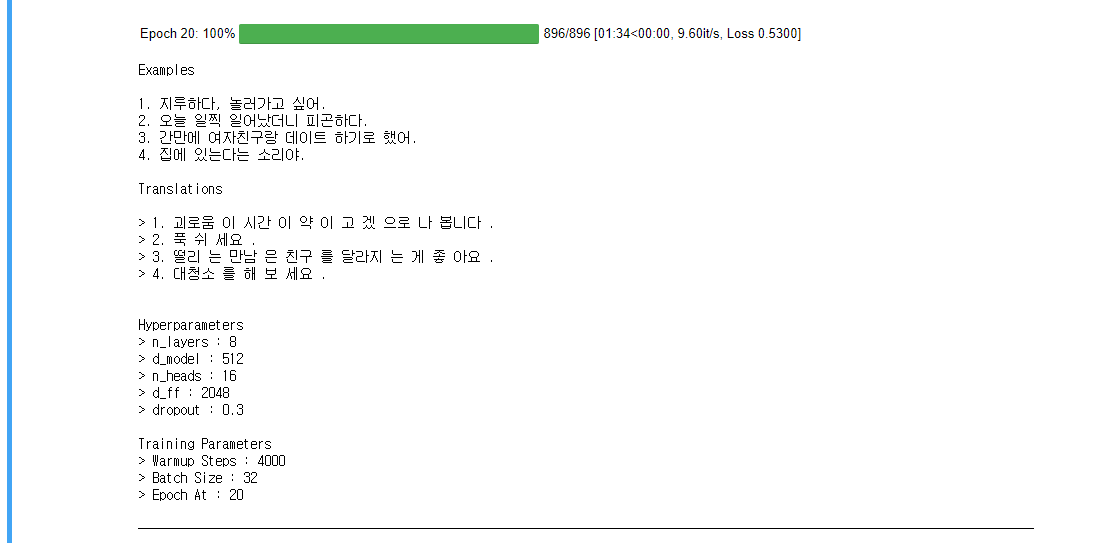

Epoch 20 의 결과를 보자. 2, 3, 4 번은 그나마 다른 epoch 출력 대비 나은 편이다.

계획은 모델을 더 작게 하려고 했는데, 작을 수록 출력 과정에서 제대로 된 것이 더 잘 안나왔다.

이전 결과 출력에서, Transformer 논문의 Base 모델 파라미터와 비슷한 규모로 모델을 설정 하였었다.

이번에는 레이어와 헤드를 늘리는 방향으로 설정하였다. 덕분에 훈련 시간이 많이 늘어났지만,

이전 모델대비 성능의 증가를 가시적으로 확인하기는 어렵다고 생각한다.

데이터도 작은 판에, 모델도 작은 경우, 과적합으로 인해 성능이 떨어지는 것으로 보이는데,

그나마 데이터와 각종 처리 부분이 동일한 조건일 때, 과적합 예방을 고려한다면 모델을 키우는 편이

성능측면에서 유리할 것이라고 생각한다.

덧붙이자면, 증강에 쓰인 유사단어 부분에도 답변 성능에서 이득을 보기 힘든 구조라 생각된다.

전혀 모르는 단어에도 대답을 어지간히 했던, 이전 14번 노드의 결과를 떠올리면,

어그멘테이션의 효과가 미미하다고 생각되지만, w2v의 성능 문제가 크다고 생각되고, 

어그멘테이션 컨셉 자체는 경우에 따라서 적용했을 경우 이득을 볼 가능성은 있을 거라고 생각된다.

&nbsp;

### Step 7. 성능 측정하기

<hr>

챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 `calculate_bleu()` 함수도 적용해 보세요.




&nbsp;


성능측정하기 스텝의 경우, 

위쪽 코드블럭에서 앞서 정리가 좀 덜 된 프로젝트_v1 부분에서의 BLEU score 및 calculate_bleu() 함수도 적용 내용이 있으므로

따로 측정을 다시 진행하진 않도록 하겠다.

<hr>

&nbsp;

### ■ 프로젝트 회고

<hr>

#### 1) 이번 프로젝트에서 '어려웠던 점'

처음부터 끝까지 어려워서 너무 힘들었다.

오류로 골머리 썩었던 적이 없는데, 데이터 모양 예시를 모르니 어떻게 해야할지 감이 안왔다.

오랜 시간동안 멘붕이 와서 한두줄 코드 작성하고 멍하고 시간 낭비를 했다.

데이터 모양을 어떻게 맞춰야 하는지 도무지 감이 안오고

노드 실습부분을 다시 실행하자니 실행시간도 시간이거니와 오류와 커널 리셋 현상 때문에 살짝 짜증이 났다.

그래도 다행스럽게 진도가 빠른 교육생이 데이터 모양을 보여주어서 나머지 부분을 진행 할 수 있었다.

트랜스포머 너무 복잡하고 어려운 것 같다. 쉽게 넘어간 부분이 없는것 같다 이번 프로젝트는.

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

트랜스포머, 데이터 증강, BLEU 스코어 등에 대해서 주로 학습했다.

자연어처리분야에서도 증강기법이라고 할 만한게 있다는게 신기하기도 하면서,

별 도움이 될까 싶었는데, 역시나 그렇게 큰 도움은 안되는 것 같다.

그래도 사용한 데이터 증강이 부족한 점이 많아서 그렇지, 개념 자체는 앞으로 개선 가능성이 충분하고

잘 사용한다면 아주 도움이 될 것 같다. 내가 그렇게 까지 극한까지 깔끔하게 사용할 능력이 안되니 문제일 뿐.

이번 프로젝트에서 사용한 수준의 증강은, 의미있게 도움을 가져왔다고 보기는 어렵다는 생각이다.

BLEU 경우도 본 프로젝트에서 대단히 큰 의미가 있었는지는 단언하기 어렵지만,

노드 학습과정에서 계산식과 설명, 그리고 프로젝트에서 실험해 보았던 경험에 비추어 볼 때,

데이터 증강에서 때와 다르게 BLEU score는, 채용해볼만한 가치가 충분하다는 생각이다.

트랜스포머는 지금까지 몇번을 보고 또 보고 그러고 있는데, 아직도 전혀 모르겠다…

아니 몰라도 그냥 모델 설계 아키텍쳐 통째로 가져다가 써도 되는건가…

아무리 번역기랑 챗봇이랑 유사하다지만, 트랜스포머 정말 무서운 것이다.

이런일을 자꾸 겪으니 더더욱 트랜스포머에 대해서 아리송해진다; 이게 된다고？

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

알아낸점은 BLEU 스코어에서 헷갈렸던 점을 조금 알 수 있었다는 점이다.

완전히는 몰라도 몇몇 궁금증은 다른 교육생들에게 물어보고 이야기 해보면서 해소할 수 있었다.

모호한 점은…

지난 트랜스포머 이용한 챗봇 프로젝트에서는 동일한 주제의 이번 프로젝트와 달리 제법 만족스러운 결과를 확인했었다.

그런데, 이전 프로젝트 시절에, 데이터셋은 동일했고, 전처리도 대충 하고, 데이터 증강 같은건 적용하지 않았었다.

파라메터도 지금보다 더 크게 했으면 했지, 훈련이 아니라 테스트 단계 또는 그냥 순수 채팅테스트 까지 수행했었는데,

모든 결과가 만족스러운 편이었고, 대부분의 평가에서 과거의 프로젝트가 지금의 프로젝트보다 훨씬 나은 결과들만 확인 할 수 있었다.

증강 과정에서 우려스러운 부분이 있어서 그부분도 최대한 살려보려고 변경도 해봤고,

혹시나 이상한 결과 생기지 않을까 싶어서 전처리도 제법 고민을 많이 했는데, 결과가 왜 이렇게 된건지…

혼란스럽고 이유가 궁금하다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

프로젝트 정상적으로 마치고 실험 결과 확인하는 등의 루브릭 평가지표는

이번에도 역시나 무사히 마무리 하면 달성 가능한 지표라고 생각한다.

전처리, 어그멘테이션, 데이터가 적다 하였는데, 이전 프로젝트에서는 모델 파라미터 더 크게 잡았지만

과적합이라 할만한 현상은 못느꼈는데, 이번 프로젝트에서 과적합이 생길꺼라고 자꾸 겁을 주길래,

모델을 줄여서도 테스트 해 봤지만, 특별히 문제될 정도로 과적합이 나타나지 않아서,

이번에도 기본값 모델로 진행 하는것으로 결정 했다. 데이터 증강의 영향인가? 싶었지만,

생각해보니 동일한 데이터셋에 데이터증강 없이 모델은 더 크게 학습했던,

지난 챗봇 프로젝트에서도 사실 과적합은 느낄 수 없었다.

바로 이전의 한영 번역기 프로젝트시에도 데이터가 적다고 했는데, 기본값 모델로 무사히 진행했었다.

번역기 프로젝트당시에 기본값 모델에서 과적합으로 피해를 안봤던 기억이 있고, 

기본값 모델이라고 사용하는 수치가, 논문에서 base로 나온 수치다보니, 안정감이 느껴진걸까…

아무튼, 모델의 loss 꾸준히 줄어드는 것을 확인했다. 데이터 증강 덕인지는 모르겠지만.

그 외 루브릭을 제외하고 프로젝트 가이드에서 스텝별로 제시된 오더들도 전부 수행하였다.

추가로 코드가 조금 뒤죽박죽하여, 완료한 프로젝트를 다시 제시된 순서대로 정리하여 실행하였다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

오류등으로 프로젝트 완성이 되지 않고 결과를 확인하지 못할 경우 말고는 상상하기 어렵다.

루브릭 평가 지표가, 챗봇응답을 확인하는 시점까지로 되어 있어서

BLEU 점수까지 가지 않더라도 이전 프로젝트의 챗봇 완성하여 디코더의 출력을 확인하는 시점 정도면

루브릭 평가지표는 거의 달성되어 있을 것이라 생각한다.

이전 버전의 챗봇을 완성 해 보았다면, 차이점은 어그멘테이션의 적용 정도라고 생각한다.

근데 루브릭 보다, 완성이 더 어렵다.

#### 6) 자기 다짐

계속 쌓여가는 프로젝트들에 치여서, 부족한 부분 공부 할 시간여유도 별로 없고, 

빠듯하게 겨우겨우 하루살이 인생마냥 힘들다. 하나 끝나면 다른 것들 또 밀려있고… 

운좋게 뭐 좀 빠르게 해도 밀려있는게 조금 줄어들 뿐 좀처럼 사라지는 느낌이 안든다.

이걸 계속 붙들고 있기엔 시간이 도무지 안될것같아서, 대충하는 것 같아 보일 수 있다.

혹자는 예전같지 않고, 나더러 변했다고 할 수도 있을 것이다.

허나 요즘 내 심정이 진짜, 이게 어려워서 뭐 좀 붙들고 파고들어가다보면

답이 안나온다, 완성도 못하고 다른건 계속 밀리고… 그런 이유로 후다닥 넘어가려는…

중요한 핵심들 빼먹지 않고 프로젝트에서 수행하고, 실험하고 그러는 것에 의의를 두는 수 밖에…

요즘 뭐 모르고 넘어가는 부분들도 점점 늘어가는 거 같고, 점점 근심걱정만 느는것 같다.

그런데, 요즘 좀 속도를 올려서, 계획 한 만큼은 아니지만, 그래도 이전보다는 많이 나아져서

밀린 것들이 조금씩이지만 줄어드는 느낌이라, 그러한 점에서는 약간 고무적이라 할 수 있겠다.



&nbsp;

<hr>

## ◎ Reference


- (AIFFEL) Going Deeper Node 10. Transformer로 번역기 만들기


- (AIFFEL) Going Deeper Node 11. 기계 번역이 걸어온 길


- (AIFFEL) Going Deeper Node 12. 번역가는 대화에도 능하다


- (AIFFEL) Exploration Project Node 14. 트랜스포머로 만드는 대화형 챗봇


- (AIFFEL) Going Deeper Node 08. Seq2seq으로 번역기 만들기


- [gensim Vocab 로드 오류 해결하기](https://iambeginnerdeveloper.tistory.com/41)

&nbsp;